### Embryo zebrafish development data: https://pubmed.ncbi.nlm.nih.gov/37468546/

In [ ]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances
import warnings
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
from collections import Counter
from scipy.stats import norm
import os
from scipy.stats import pearsonr



Load ATAC data

In [31]:
atac_data_df = pd.read_csv('../../data/embryo/raw/atac_peak_matrix_complete_sparse.csv', index_col=0)



Load RNA data and log transform them

In [32]:
rna_data = pl.read_csv("../../data/embryo/raw/scRNA_countMatrix.csv", ignore_errors=True)
# Convert to dictionary first, then to pandas
data_dict = rna_data.to_dict(as_series=False)
rna_data_df = pd.DataFrame(data_dict)
# make 1st colun the index 
rna_data_df.set_index(rna_data_df.columns[0], inplace=True)
# remove empty rows and columns and set gene names as index
rna_data_df[rna_data_df.isna().any(axis=1)]
rna_data_df.dropna(axis=0, how='any', inplace=True)
# transform rna data - log2(x+1) for downstream steps
rna_data_log = rna_data_df.copy()
rna_data_log.iloc[:, 0:] = np.log2(rna_data_log.iloc[:, 0:].astype(float) + 1)
rna_data_log


10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                                      
rpl13a                            5.554589                 4.523562   
khdrbs1a                          6.357552                 5.906891   
apoeb                             6.614710                 6.870365   
cfl1                              3.584963                 3.321928   
polr2d                            2.584963                 1.000000   
...                                    ...                      ...   
CU570797.5                        0.000000                 0.000000   
trgv5                             0.000000                 0.000000   
BX950188.3                        0.000000                 0.000000   
BX548038.2                        0.000000                 0.000000   
si:ch1073-394i4.1                 0.000000                 0.000000   

                   10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                                      
rpl13a                            4.807355                 4.247928   
khdrbs1a                          5.209453                 5.930737   
apoeb                             7.599913                 4.700440   
cfl1                              3.459432                 4.459432   
polr2d                            1.000000                 2.807355   
...                                    ...                      ...   
CU570797.5                        0.000000                 0.000000   
trgv5                             0.000000                 0.000000   
BX950188.3                        0.000000                 0.000000   
BX548038.2                        0.000000                 0.000000   
si:ch1073-394i4.1                 0.000000                 0.000000   

                   10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                                   
rpl13a                          6.209453                6.228819   
khdrbs1a                        7.294621                7.375039   
apoeb                           4.754888                9.144658   
cfl1                            4.954196                5.247928   
polr2d                          2.000000                2.000000   
...                                  ...                     ...   
CU570797.5                      0.000000                0.000000   
trgv5                           0.000000                0.000000   
BX950188.3                      0.000000                0.000000   
BX548038.2                      0.000000                0.000000   
si:ch1073-394i4.1               0.000000                0.000000   

                   10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                                    
rpl13a                           6.507795                6.599913   
khdrbs1a                         7.531381                7.599913   
apoeb                            6.554589                5.554589   
cfl1                             5.614710                6.044394   
polr2d                           2.584963                2.807355   
...                                   ...                     ...   
CU570797.5                       0.000000                0.000000   
trgv5                            0.000000                0.000000   
BX950188.3                       0.000000                0.000000   
BX548038.2                       0.000000                0.000000   
si:ch1073-394i4.1                0.000000                0.000000   

                   10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                                   ...   
rpl13a                           5.882643                5.754888  ...   
khdrbs1a                         6.894818                7.228819  ...   
apoeb                            6.569856                7.149747  ...   
cfl1              

Load metadata

In [5]:
rna_metadata_df = pd.read_csv('../../data/embryo/raw/rna_all.metaData.txt')
rna_metadata_df.rename(columns = {'Unnamed: 0': 'rna_cell'}, inplace=True)
rna_metadata_df


rna_cell orig.ident  nCount_RNA  nFeature_RNA  \
0      10h-1_CELL1140_N1_10h-1      10h-1       16009          3354   
1      10h-1_CELL1447_N1_10h-1      10h-1       11259          2505   
2      10h-1_CELL1347_N1_10h-1      10h-1       12532          2806   
3      10h-1_CELL1204_N1_10h-1      10h-1       14432          3312   
4        10h-1_CELL97_N2_10h-1      10h-1       31455          4443   
...                        ...        ...         ...           ...   
68848       6h_3 CELL5349_N1 _     6hpf_3        2708          1097   
68849       6h_3 CELL4434_N1 _     6hpf_3        3852          1492   
68850       6h_3 CELL5403_N1 _     6hpf_3        2694          1098   
68851       6h_3 CELL5489_N1 _     6hpf_3        2602           972   
68852       6h_3 CELL5447_N1 _     6hpf_3        2626          1097   

       percent.mt  seurat_clusters  stage               celltype  
0        1.467924               14  10hpf   anterior neural keel  
1        1.367795                3  10hpf     neurogenic placode  
2        1.324609               22  10hpf        epithelial Cell  
3        1.489745                8  10hpf               tail bud  
4        1.176284                2  10hpf  posterior neural keel  
...           ...              ...    ...                    ...  
68848    1.289134                1   6hpf               epiblast  
68849    1.011936                1   6hpf               epiblast  
68850    0.667904                1   6hpf               epiblast  
68851    1.345119                1   6hpf               epiblast  
68852    0.837776                1   6hpf               epiblast  

[68853 rows x 8 columns]

In [6]:
atac_metadata_df = (
    pd.read_csv('../../data/embryo/raw/atac_all.metaData.txt', index_col=0)
    [['celltype', 'predictedCell', 'predictedGroup']]
    .rename(columns={
        'celltype': 'atac_cell_type',
        'predictedCell': 'rna_matching_cell',
        'predictedGroup': 'rna_cell_type'
    })
    .reset_index(names="atac_cell")
)

def extract_stage(cell_id, delimiter='h', pos=0):
    return str(cell_id).split(delimiter)[pos].replace('h', '')

atac_metadata_df = atac_metadata_df.assign(
    rna_stage=lambda df: df['rna_matching_cell'].apply(extract_stage, args=('h', 0)),
    atac_stage=lambda df: df['atac_cell'].apply(extract_stage, args=('hpf', 0)),
    pseudobulk=lambda df: df['atac_stage'] + '_' + df['atac_cell_type']
)

atac_metadata_df.head()

atac_cell atac_cell_type    rna_matching_cell  \
0  3hpf_1#3hpf_1_merge_BC0443_N27     blastomere   6h_3 CELL4645_N1 _   
1  3hpf_1#3hpf_1_merge_BC0069_N07     blastomere  3h1_CELL1337_N1_3h1   
2  3hpf_1#3hpf_1_merge_BC0033_N05     blastomere  3h1_CELL1337_N1_3h1   
3  3hpf_1#3hpf_1_merge_BC0028_N08     blastomere  3h1_CELL1197_N1_3h1   
4  3hpf_1#3hpf_1_merge_BC0264_N08     blastomere  3h1_CELL1197_N1_3h1   

  rna_cell_type rna_stage atac_stage    pseudobulk  
0        margin         6          3  3_blastomere  
1    blastomere         3          3  3_blastomere  
2    blastomere         3          3  3_blastomere  
3    blastomere         3          3  3_blastomere  
4    blastomere         3          3  3_blastomere

Create ATAC **mean** and **std** dataframes - group cells by same pseudobulk

In [7]:
celltype_lookup = dict(zip(atac_metadata_df['atac_cell'], atac_metadata_df['atac_cell_type']))
atac_data_df['stage'] = atac_data_df['Cell'].str.extract(r'(\d{1,2})[a-zA-Z]', expand=False)
atac_data_df['celltype'] = atac_data_df['Cell'].map(celltype_lookup)
atac_data_df['stage_celltype'] = atac_data_df['stage'] + '_' + atac_data_df['celltype']

def create_stats_df_atac(df, min_cells=None):
    if min_cells is not None:
        pseudobulk_counts = df.groupby('stage_celltype')['Cell'].nunique()
        valid_stage_celltypes = pseudobulk_counts.index[pseudobulk_counts >= min_cells]
        df = df[df['stage_celltype'].isin(valid_stage_celltypes)]

    grouped = df.groupby(['Peak', 'stage_celltype'])['Accessibility']
    mean_df = grouped.mean().unstack(fill_value=0)
    std_df = grouped.std().unstack(fill_value=0).fillna(0)

    return mean_df, std_df

atac_mean_full, atac_std_full = create_stats_df_atac(atac_data_df)
atac_mean_filtered, atac_std_filtered = create_stats_df_atac(atac_data_df, min_cells=10)

atac_mean_filtered


stage_celltype           10_UND    10_YSL  10_anterior/posterior axis  \
Peak                                                                    
chr10:10002124-10002624     2.0  2.000000                    1.800000   
chr10:10003707-10004207     1.0  0.000000                    2.000000   
chr10:10004747-10005247     2.0  0.000000                    1.750000   
chr10:10008047-10008547     2.0  0.000000                    2.060606   
chr10:10009662-10010162     0.0  0.000000                    1.800000   
...                         ...       ...                         ...   
chr9:998557-999057          0.0  1.000000                    2.000000   
chr9:9989556-9990056        2.0  1.958333                    1.500000   
chr9:9992990-9993490        2.0  1.333333                    1.000000   
chr9:9997607-9998107        1.5  2.461538                    1.333333   
chr9:9998460-9998960        0.0  2.000000                    1.000000   

stage_celltype           10_lateral plate mesoderm  10_neural crest  \
Peak                                                                  
chr10:10002124-10002624                   2.000000         2.000000   
chr10:10003707-10004207                   0.000000         2.000000   
chr10:10004747-10005247                   2.333333         2.285714   
chr10:10008047-10008547                   2.250000         2.200000   
chr10:10009662-10010162                   0.000000         1.750000   
...                                            ...              ...   
chr9:998557-999057                        1.000000         1.500000   
chr9:9989556-9990056                      2.000000         1.500000   
chr9:9992990-9993490                      2.000000         0.000000   
chr9:9997607-9998107                      1.000000         0.000000   
chr9:9998460-9998960                      2.000000         2.000000   

stage_celltype           10_neural keel  10_periderm/epidermis  \
Peak                                                             
chr10:10002124-10002624        2.166667               4.000000   
chr10:10003707-10004207        1.888889               0.000000   
chr10:10004747-10005247        2.153846               1.666667   
chr10:10008047-10008547        2.116279               2.000000   
chr10:10009662-10010162        2.000000               1.500000   
...                                 ...                    ...   
chr9:998557-999057             2.000000               0.000000   
chr9:9989556-9990056           2.750000               2.000000   
chr9:9992990-9993490           1.000000               1.000000   
chr9:9997607-9998107           2.333333               4.000000   
chr9:9998460-9998960           1.666667               0.000000   

stage_celltype           10_segmental plate  12_UND  12_YSL  ...  \
Peak                                                         ...   
chr10:10002124-10002624            2.000000     0.0     0.0  ...   
chr10:10003707-10004207            1.666667     0.0     0.0  ...   
chr10:10004747-10005247            1.666667     2.0     1.0  ...   
chr10:10008047-10008547            2.250000     2.0     2.0  ...   
chr10:10009662-10010162            3.000000     0.0     0.0  ...   
...                                     ...     ...     ...  ...   
chr9:998557-999057                 2.166667     0.0     1.0  ...   
chr9:9989556-9990056               2.000000     0.0     2.6  ...   
chr9:9992990-9993490               0.000000     0.0     0.0  ...   
chr9:9997607-9998107               1.666667     1.0     2.8  ...   
chr9:9998460-9998960               2.000000     0.0     0.0  ...   

stage_celltype           24_segmental plate  3_blastomere     5_EVL  \
Peak                                                                  
chr10:10002124-10002624                 0.0      1.413043  1.571429   
chr10:10003707-10004207                 0.0      1.673469  1.545455   
chr10:10004747-10005247                 2.0      1.658537  1.666667   
chr10:10008047-10008547    

Plot the amount of cells in through cell trajectories 


Stages per cell type with cell counts:
              atac_cell_type             stages  cell_counts_per_stage
5                 blastomere  [3, 5, 6, 18, 24]     [4658, 2, 5, 5, 6]
2                        YSL   [10, 12, 18, 24]   [205, 129, 165, 134]
1                        UND   [10, 12, 18, 24]  [324, 201, 504, 1379]
4    anterior/posterior axis   [10, 12, 18, 24]    [709, 364, 115, 15]
15           mesenchyme cell   [10, 12, 18, 24]      [2, 3, 594, 2165]
22           segmental plate   [10, 12, 18, 24]    [836, 519, 456, 91]
20        periderm/epidermis   [10, 12, 18, 24]   [143, 166, 235, 448]
21            primary neuron       [12, 18, 24]         [1, 100, 1497]
14    lateral plate mesoderm       [10, 12, 18]          [599, 338, 7]
6     central nervous system       [12, 18, 24]         [27, 3599, 46]
13                integument       [12, 18, 24]         [10, 379, 947]
16        musculature system       [12, 18, 24]         [13, 553, 789]
18               neural keel       [1

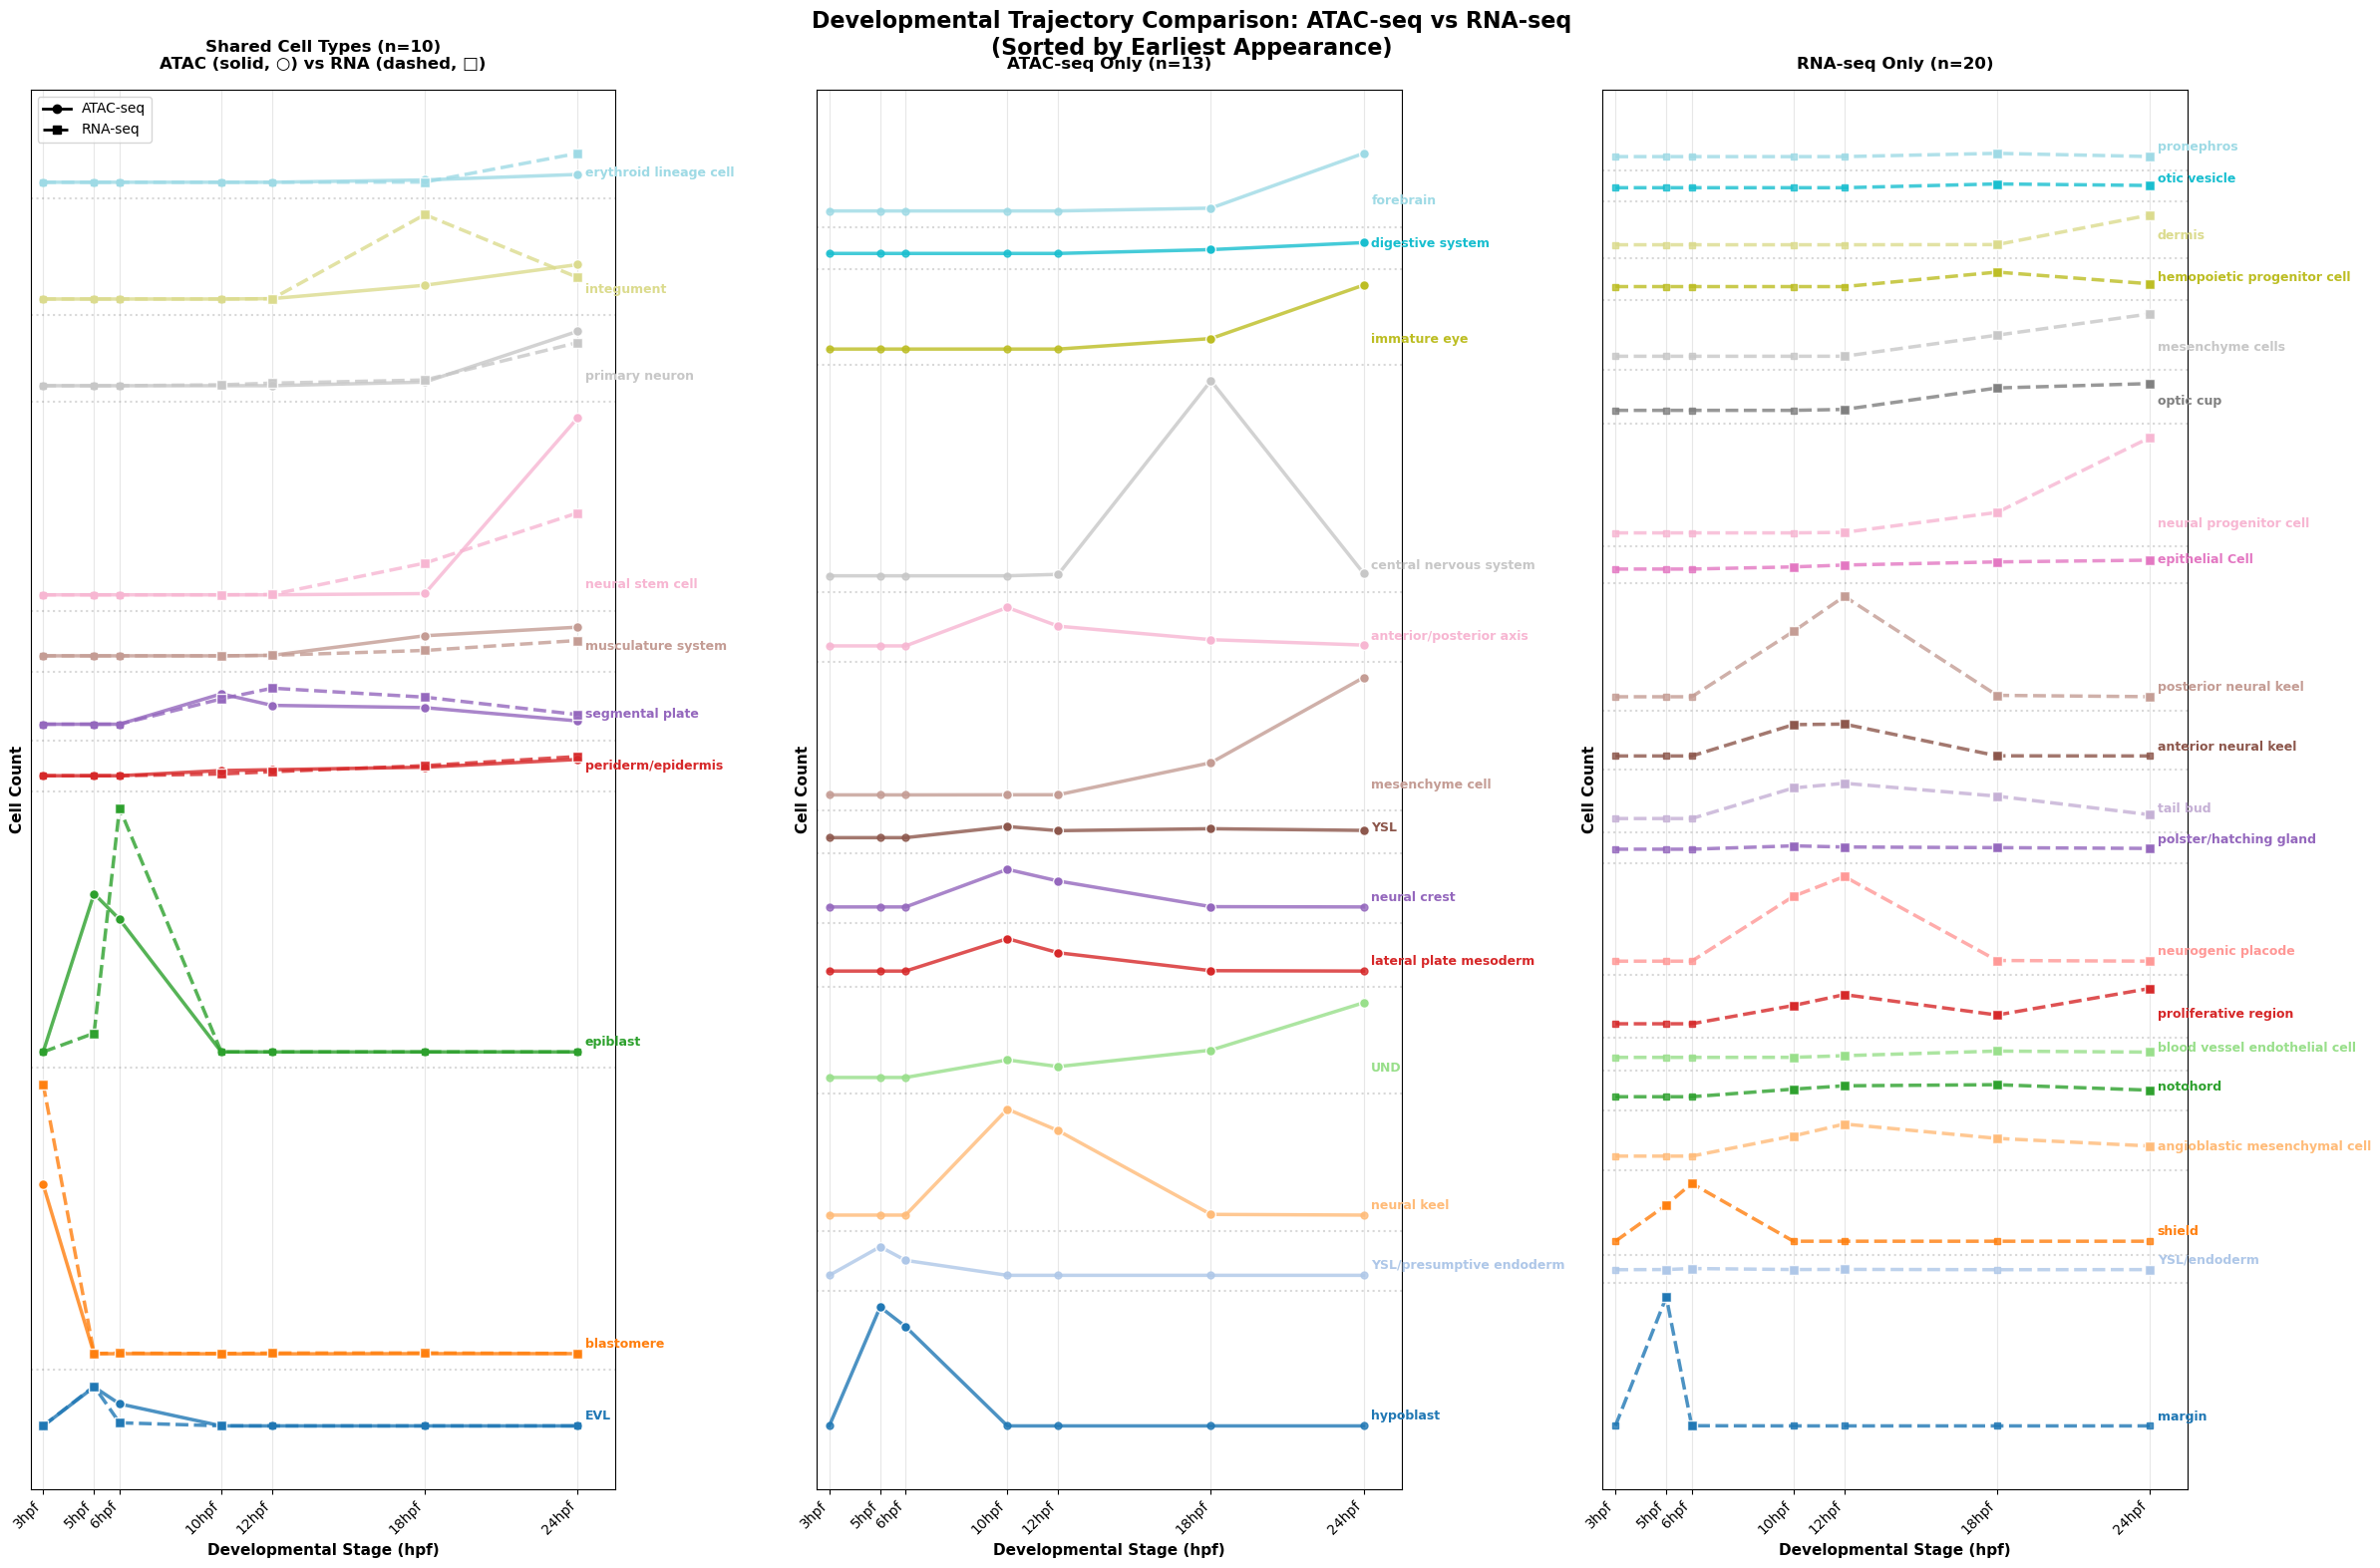

In [9]:
# Three-Panel ATAC vs RNA Developmental Trajectory Comparison
atac_counts_per_psd = atac_metadata_df.groupby('pseudobulk')['atac_cell'].nunique().reset_index(name='ATAC')
# filter out pseudobulks with less than 20 cells
atac_counts_per_psd = atac_counts_per_psd[atac_counts_per_psd['ATAC'] >= 20]
rna_counts_per_psd = atac_metadata_df.groupby('pseudobulk')['rna_matching_cell'].nunique().reset_index(name='RNA')
rna_counts_per_psd = rna_counts_per_psd[rna_counts_per_psd['RNA'] >= 20]
stages_per_celltype = atac_metadata_df.groupby('atac_cell_type')['atac_stage'].unique().reset_index()
stages_per_celltype.rename(columns={'atac_stage': 'stages'}, inplace=True)

stages_per_celltype.sort_values(by='stages', key=lambda x: x.str.len(), ascending=False, inplace=True)
def get_cell_counts_per_stage(row):
    cell_type = row['atac_cell_type']
    stages = row['stages']
    
    cell_counts = []
    for stage in stages:
        pseudobulk_id = f"{stage}_{cell_type}"
        count = atac_metadata_df[atac_metadata_df['pseudobulk'] == pseudobulk_id]['atac_cell'].nunique()
        cell_counts.append(count)
    
    return cell_counts

stages_per_celltype['cell_counts_per_stage'] = stages_per_celltype.apply(get_cell_counts_per_stage, axis=1)

print("\nStages per cell type with cell counts:")
print(stages_per_celltype)

def extract_stage_number(stage_str):
    """Extract numeric value from stage string (e.g., '10hpf' -> 10)"""
    import re
    match = re.search(r'(\d+)', str(stage_str))
    return int(match.group(1)) if match else 0

def process_trajectory_data(df, cell_type_col, stage_col):
    """Process dataframe to create trajectory data"""
    stage_celltype_counts = df.groupby([cell_type_col, stage_col]).size().reset_index(name='count')
    stage_celltype_counts['stage_numeric'] = stage_celltype_counts[stage_col].apply(extract_stage_number)
    heatmap_data = stage_celltype_counts.pivot(index=cell_type_col, columns='stage_numeric', values='count')
    heatmap_data = heatmap_data.fillna(0)
    heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)
    
    return heatmap_data

def get_earliest_stage_unified(cell_type, atac_data, rna_data):
    """Get earliest stage for a cell type across both datasets"""
    earliest = float('inf')

    if atac_data is not None and cell_type in atac_data.index:
        for stage in sorted(atac_data.columns):
            if atac_data.loc[cell_type, stage] > 0:
                earliest = min(earliest, int(stage))
                break
    
    # Check RNA data
    if rna_data is not None and cell_type in rna_data.index:
        for stage in sorted(rna_data.columns):
            if rna_data.loc[cell_type, stage] > 0:
                earliest = min(earliest, int(stage))
                break
    
    return earliest if earliest != float('inf') else 999

def get_earliest_stage_single(row):
    """Get earliest stage for a single dataset"""
    for stage in sorted(row.index):
        if row[stage] > 0:
            return int(stage)
    return float('inf')

def plot_trajectories(ax, cell_types, atac_data, rna_data, all_stages, title, plot_type):
    """Plot trajectories for given cell types"""
    
    if len(cell_types) == 0:
        ax.text(0.5, 0.5, 'No cell types in this category', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
        return
    if plot_type == 'shared':
        cell_types_sorted = sorted(cell_types, 
                                  key=lambda x: get_earliest_stage_unified(x, atac_data, rna_data))
    elif plot_type == 'atac_only':
        cell_types_sorted = sorted(cell_types, 
                                  key=lambda x: get_earliest_stage_unified(x, atac_data, None))
    else:  # rna_only
        cell_types_sorted = sorted(cell_types, 
                                  key=lambda x: get_earliest_stage_unified(x, None, rna_data))
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(cell_types_sorted)))
    color_map = {cell_type: colors[i] for i, cell_type in enumerate(cell_types_sorted)}
    
    y_offset = 0
    max_counts = []
    if atac_data is not None:
        max_counts.append(atac_data.values.max())
    if rna_data is not None:
        max_counts.append(rna_data.values.max())
    max_count = max(max_counts) if max_counts else 1000
    
    y_spacing = max(500, max_count * 0.12)
    cell_type_positions = {}
    
    for cell_type in cell_types_sorted:
        cell_color = color_map[cell_type]
        max_y_for_cell = 0
    
        if atac_data is not None and cell_type in atac_data.index:
            atac_y_values = []
            for stage in all_stages:
                if stage in atac_data.columns:
                    atac_y_values.append(atac_data.loc[cell_type, stage])
                else:
                    atac_y_values.append(0)
            
            atac_y_values_offset = [val + y_offset for val in atac_y_values]
            max_y_for_cell = max(max_y_for_cell, max(atac_y_values))
            
            ax.plot(all_stages, atac_y_values_offset, marker='o', linewidth=2.5, 
                   markersize=5, color=cell_color, alpha=0.8, linestyle='-',
                   label=f'{cell_type} (ATAC)' if plot_type == 'shared' else cell_type)
            
            non_zero_stages = [stage for stage, count in zip(all_stages, atac_y_values) if count > 0]
            non_zero_counts = [count + y_offset for count in atac_y_values if count > 0]
            if non_zero_stages:
                ax.scatter(non_zero_stages, non_zero_counts, color=cell_color, 
                          s=50, zorder=5, alpha=0.9, marker='o', edgecolor='white', linewidth=1)
        
        if rna_data is not None and cell_type in rna_data.index:
            rna_y_values = []
            for stage in all_stages:
                if stage in rna_data.columns:
                    rna_y_values.append(rna_data.loc[cell_type, stage])
                else:
                    rna_y_values.append(0)
            
            rna_y_values_offset = [val + y_offset for val in rna_y_values]
            max_y_for_cell = max(max_y_for_cell, max(rna_y_values))
            
            ax.plot(all_stages, rna_y_values_offset, marker='s', linewidth=2.5, 
                   markersize=5, color=cell_color, alpha=0.8, linestyle='--',
                   label=f'{cell_type} (RNA)' if plot_type == 'shared' else cell_type)
            
            non_zero_stages = [stage for stage, count in zip(all_stages, rna_y_values) if count > 0]
            non_zero_counts = [count + y_offset for count in rna_y_values if count > 0]
            if non_zero_stages:
                ax.scatter(non_zero_stages, non_zero_counts, color=cell_color, 
                          s=50, zorder=5, alpha=0.9, marker='s', edgecolor='white', linewidth=1)
        
        cell_type_positions[cell_type] = y_offset
        y_offset += max_y_for_cell + y_spacing
    
    for cell_type, y_pos in cell_type_positions.items():
        ax.text(max(all_stages) + 0.3, y_pos + y_spacing*0.1, cell_type, 
                va='bottom', ha='left', fontsize=9, fontweight='bold',
                color=color_map[cell_type])
    
    # Customize the plot
    ax.set_xlabel('Developmental Stage (hpf)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Cell Count', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
    
    # Set x-axis
    ax.set_xticks(all_stages)
    ax.set_xticklabels([f'{stage}hpf' for stage in all_stages], rotation=45, ha='right')
    ax.set_xlim(min(all_stages)-0.5, max(all_stages)+1.5)
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, axis='x')
    for i, y_pos in enumerate(cell_type_positions.values()):
        if i > 0:
            ax.axhline(y=y_pos - y_spacing/2, color='gray', linestyle=':', alpha=0.3)
print("Processing ATAC-seq data...")
try:
    atac_heatmap = process_trajectory_data(atac_metadata_df, 'atac_cell_type', 'atac_stage')
    atac_available = True
    print(f"ATAC data processed: {len(atac_heatmap)} cell types")
except Exception as e:
    print(f"ATAC data not available: {e}")
    atac_available = False
    atac_heatmap = None
rna_heatmap = process_trajectory_data(rna_metadata_df, 'celltype', 'stage')

if atac_available:
    all_cell_types = set(atac_heatmap.index) | set(rna_heatmap.index)
    common_cell_types = set(atac_heatmap.index) & set(rna_heatmap.index)
    atac_only = set(atac_heatmap.index) - set(rna_heatmap.index)
    rna_only = set(rna_heatmap.index) - set(atac_heatmap.index)
    
    # Get all stages (union of both datasets)
    all_stages = sorted(set(atac_heatmap.columns) | set(rna_heatmap.columns))
    
    print(f"\nDataset overlap:")
    print(f"Common cell types: {len(common_cell_types)}")
    print(f"ATAC-only: {len(atac_only)}")
    print(f"RNA-only: {len(rna_only)}")
    print(f"Total unique: {len(all_cell_types)}")
    
else:
    # If no ATAC data, all are RNA-only
    common_cell_types = set()
    atac_only = set()
    rna_only = set(rna_heatmap.index)
    all_stages = sorted(rna_heatmap.columns)

fig, axes = plt.subplots(1, 3, figsize=(24, 16))

plot_trajectories(axes[0], common_cell_types, 
                 atac_heatmap if atac_available else None, 
                 rna_heatmap, all_stages, 
                 f'Shared Cell Types (n={len(common_cell_types)})\nATAC (solid, ○) vs RNA (dashed, □)', 
                 'shared')

plot_trajectories(axes[1], atac_only, 
                 atac_heatmap if atac_available else None, 
                 None, all_stages, 
                 f'ATAC-seq Only (n={len(atac_only)})', 
                 'atac_only')
plot_trajectories(axes[2], rna_only, 
                 None, rna_heatmap, all_stages, 
                 f'RNA-seq Only (n={len(rna_only)})', 
                 'rna_only')

fig.suptitle('Developmental Trajectory Comparison: ATAC-seq vs RNA-seq\n(Sorted by Earliest Appearance)', 
             fontsize=16, fontweight='bold', y=0.98)
if len(common_cell_types) > 0 and atac_available:
    legend_elements = [
        plt.Line2D([0], [0], color='black', linewidth=2, linestyle='-', marker='o', 
                   markersize=6, label='ATAC-seq'),
        plt.Line2D([0], [0], color='black', linewidth=2, linestyle='--', marker='s', 
                   markersize=6, label='RNA-seq')
    ]
    axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()
plt.subplots_adjust(top=0.93)
fig_path = '../../data/embryo/plots/atac_rna_developmental_trajectories_comparison.png'
plt.savefig(fig_path, bbox_inches='tight')
plt.show()




#### Only 2258 RNA cells are assigned to ATAC cells

In [10]:
# filter rna_data_log to only keep the rows with max  value >=4
rna_log_high_genes = rna_data_log[rna_data_log.max(axis=1) >= 4]
rna_log_high_genes

10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                             
rpl13a                   5.554589                 4.523562   
khdrbs1a                 6.357552                 5.906891   
apoeb                    6.614710                 6.870365   
cfl1                     3.584963                 3.321928   
polr2d                   2.584963                 1.000000   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                             
rpl13a                   4.807355                 4.247928   
khdrbs1a                 5.209453                 5.930737   
apoeb                    7.599913                 4.700440   
cfl1                     3.459432                 4.459432   
polr2d                   1.000000                 2.807355   
...                           ...                      ...   
tmc2a                    0.000000                 0.000000   
gnb3a                    0.000000                 0.000000   
cd164l2                  0.000000                 0.000000   
cpa5                     0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                          
rpl13a                 6.209453                6.228819   
khdrbs1a               7.294621                7.375039   
apoeb                  4.754888                9.144658   
cfl1                   4.954196                5.247928   
polr2d                 2.000000                2.000000   
...                         ...                     ...   
tmc2a                  0.000000                0.000000   
gnb3a                  0.000000                0.000000   
cd164l2                0.000000                0.000000   
cpa5                   0.000000                0.000000   
dharma                 0.000000                0.000000   

          10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                           
rpl13a                  6.507795                6.599913   
khdrbs1a                7.531381                7.599913   
apoeb                   6.554589                5.554589   
cfl1                    5.614710                6.044394   
polr2d                  2.584963                2.807355   
...                          ...                     ...   
tmc2a                   0.000000                0.000000   
gnb3a                   0.000000                0.000000   
cd164l2                 0.000000                0.000000   
cpa5                    0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                          ...   
rpl13a                  5.882643                5.754888  ...   
khdrbs1a                6.894818                7.228819  ...   
apoeb                   6.569856                7.149747  ...   
cfl1                    4.906891                5.392317  ...   
polr2d                  1.000000                3.000000  ...   
...                          ...                     ...  ...   
tmc2a                   0.000000                0.000000  ...   
gnb3a                   0.000000                0.000000  ...   
cd164l2                 0.000000                0.000000  ...   
cpa5                    0.000000                0.000000  ...   
dharma                  0.000000                0.000000  ...   

 

In [11]:

# continue with log values anf filtered genes 
# split the rna_data_log into matched and unmatched based on the atac_metadata_df
matching_cells = atac_metadata_df['rna_matching_cell'].str.strip().unique().tolist()
rna_data_matched_all_genes = rna_data_log.loc[:, rna_data_log.columns.intersection(matching_cells)]
rna_data_unmatched_all_genes =rna_data_log.loc[:, ~rna_data_log.columns.isin(matching_cells)]
matching_cells = atac_metadata_df['rna_matching_cell'].str.strip().unique().tolist()
rna_high_genes_Matched = rna_log_high_genes.loc[:, rna_log_high_genes.columns.intersection(matching_cells)]
rna_high_genes_Unmatched = rna_log_high_genes.loc[:, ~rna_log_high_genes.columns.isin(matching_cells)]
print("shape of rna_high_genes_Matched:", rna_high_genes_Matched.shape)
print("shape of rna_high_genes_Unmatched:", rna_high_genes_Unmatched.shape)

rna_high_genes_Unmatched.head()



shape of rna_high_genes_Matched: (9205, 2258)
shape of rna_high_genes_Unmatched: (9205, 66595)


10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                             
rpl13a                   5.554589                 4.523562   
khdrbs1a                 6.357552                 5.906891   
apoeb                    6.614710                 6.870365   
cfl1                     3.584963                 3.321928   
polr2d                   2.584963                 1.000000   

          10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                             
rpl13a                   4.807355                 4.247928   
khdrbs1a                 5.209453                 5.930737   
apoeb                    7.599913                 4.700440   
cfl1                     3.459432                 4.459432   
polr2d                   1.000000                 2.807355   

          10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                          
rpl13a                 6.209453                6.228819   
khdrbs1a               7.294621                7.375039   
apoeb                  4.754888                9.144658   
cfl1                   4.954196                5.247928   
polr2d                 2.000000                2.000000   

          10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                           
rpl13a                  6.507795                6.599913   
khdrbs1a                7.531381                7.599913   
apoeb                   6.554589                5.554589   
cfl1                    5.614710                6.044394   
polr2d                  2.584963                2.807355   

          10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                          ...   
rpl13a                  5.882643                5.754888  ...   
khdrbs1a                6.894818                7.228819  ...   
apoeb                   6.569856                7.149747  ...   
cfl1                    4.906891                5.392317  ...   
polr2d                  1.000000                3.000000  ...   

          6h_3 CELL3882_N1 _  6h_3 CELL5301_N1 _  6h_3 CELL5240_N1 _  \
                                                                       
rpl13a              2.321928            0.000000            1.584963   
khdrbs1a            5.459432            4.906891            4.459432   
apoeb               3.584963            3.000000            3.321928   
cfl1                3.169925            2.000000            1.584963   
polr2d              0.000000            0.000000            0.000000   

          6h_3 CELL5143_N1 _  6h_3 CELL5575_N1 _  6h_3 CELL5349_N1 _  \
                                                                       
rpl13a              2.000000            1.584963            1.584963   
khdrbs1a            3.906891            4.584963            4.584963   
apoeb               4.087463            4.321928            3.459432   
cfl1                1.000000            2.000000            1.584963   
polr2d              1.584963            0.000000            0.000000   

          6h_3 CELL4434_N1 _  6h_3 CELL5403_N1 _  6h_3 CELL5489_N1 _  \
                                                                       
rpl13a              2.000000            3.000000            1.000000   
khdrbs1a            5.129283            4.584963            4.807355   
apoeb               4.321928            2.321928            1.584963   
cfl1                3.169925            2.584963            2.000000   
polr2d              1.000000            1.000000            1.000000   

          6h_3 CELL5447_N1 _  
                              
rpl13a              1.000000  
khdrbs1a            5.700440  
apoeb               1.000000  
cfl1                2.807355  
polr2d              2.000000  

[5 rows x 66595 columns]

##### Define a cutoff for each pseudobulk as the distance between this (mean vector of same psd cells) and the most distant cell of the same celltype (from any time point).
##### Compute the distance from same cell type cells to each pseudobulk considering only genes with max log expression >=4
    - To enrich the pseudobulks with unmatched RNA cells we will use this cutoff
    - If a new cell has a distance > cutoff, it is more different than any cell of that type used to define the pseudobulk 

In [12]:
def compute_pseudobulk_cutoffs_df(rna_data_matched, atac_metadata, marker_genes_dict=None, cutoff_mode='celltype'):
    metadata = atac_metadata.set_index('rna_matching_cell').loc[rna_data_matched.columns].reset_index(names='rna_matching_cell')
    pseudobulk_names = metadata['pseudobulk'].unique()
    results = []
    
    for pb in pseudobulk_names:
        celltype = metadata[metadata['pseudobulk'] == pb]['atac_cell_type'].iloc[0]
        cells_in_pb = metadata[metadata['pseudobulk'] == pb]['rna_matching_cell']
        same_type_cells = metadata[metadata['atac_cell_type'] == celltype]['rna_matching_cell']
        same_type_pseudobulks = metadata[metadata['atac_cell_type'] == celltype]['pseudobulk'].unique()

        if len(same_type_cells) == 0:
            continue

        if marker_genes_dict is not None:
            marker_genes = marker_genes_dict.get(pb, [])
            marker_genes = [g for g in marker_genes if g in rna_data_matched.index]
            genes_to_use = marker_genes
        else:
            genes_to_use = rna_data_matched.index
        
        mean_expression = rna_data_matched.loc[genes_to_use, cells_in_pb].mean(axis=1)
        mean_vec_reshaped = mean_expression.values.reshape(1, -1)

        if cutoff_mode == 'pseudobulk':
            # Compute distances from cells of the same type to the pseudobulk mean expression vector
            same_type_matrix = rna_data_matched.loc[genes_to_use, same_type_cells].T.values
            distances = cdist(same_type_matrix, mean_vec_reshaped, metric='euclidean').flatten()
            cutoff = distances.max()
        elif cutoff_mode == 'celltype':
            # Compute the mean expression vector of all pseudobulks with the same cell type
            mean_same_type_expression = rna_data_matched.loc[genes_to_use, metadata[metadata['pseudobulk'].isin(same_type_pseudobulks)]['rna_matching_cell']].mean(axis=1)
            mean_same_type_vec_reshaped = mean_same_type_expression.values.reshape(1, -1)
            # Compute distances from all same cell type cells to this mean vector
            same_type_matrix = rna_data_matched.loc[genes_to_use, same_type_cells].T.values
            distances = cdist(same_type_matrix, mean_same_type_vec_reshaped, metric='euclidean').flatten()
            cutoff = distances.max()
        else:
            raise ValueError("Invalid cutoff_mode. Use 'max_distance' or 'mean_distance'.")
        
        results.append({
            'pseudobulk': pb,
            'atac_cell_type': celltype,
            'cutoff': cutoff,
            'n_cells_in_pseudobulk': len(cells_in_pb),
            'n_cells_same_type': len(same_type_cells)
        })
    
    return pd.DataFrame(results)


cutoffs_high_exp_genes_Celltype = compute_pseudobulk_cutoffs_df(rna_high_genes_Matched, atac_metadata_df, cutoff_mode='celltype')
cutoffs_high_exp_genes_Pseudobulk = compute_pseudobulk_cutoffs_df(rna_high_genes_Matched, atac_metadata_df, cutoff_mode='pseudobulk')
print(cutoffs_high_exp_genes_Celltype.head())
print(cutoffs_high_exp_genes_Pseudobulk.head())

                  pseudobulk          atac_cell_type      cutoff  \
0             12_neural keel             neural keel  146.972241   
1  18_central nervous system  central nervous system  173.703086   
2            10_neural crest            neural crest  118.172175   
3            12_neural crest            neural crest  118.172175   
4              12_integument              integument  137.452094   

   n_cells_in_pseudobulk  n_cells_same_type  
0                   1557               3525  
1                   3599               3672  
2                    694               1177  
3                    478               1177  
4                     10               1336  
                  pseudobulk          atac_cell_type      cutoff  \
0             12_neural keel             neural keel  138.797406   
1  18_central nervous system  central nervous system  173.781686   
2            10_neural crest            neural crest  118.594639   
3            12_neural crest            neu

Create mean and std fataframes for RNA -only for the pseudobulks with more than 10 ATAC cells
- keep the pseudobulks with a few RNA original assignments since the marker genes will be computed according to all time points of the same pseudobulk

In [13]:
def create_rna_mean(rna_data, atac_metadata_df, valid_pseudobulks):
    cell_to_pseudobulk = atac_metadata_df.set_index('rna_matching_cell')['pseudobulk'].to_dict()
    rna_data_psd = rna_data.rename(columns=cell_to_pseudobulk)
    rna_data_filtered = rna_data_psd.loc[:, rna_data_psd.columns.intersection(valid_pseudobulks)]
    return rna_data_filtered.groupby(level=0, axis=1).mean()

def create_rna_std(rna_data, atac_metadata_df, valid_pseudobulks):
    cell_to_pseudobulk = atac_metadata_df.set_index('rna_matching_cell')['pseudobulk'].to_dict()
    rna_data_psd = rna_data.rename(columns=cell_to_pseudobulk)
    rna_data_filtered = rna_data_psd.loc[:, rna_data_psd.columns.intersection(valid_pseudobulks)]
    return rna_data_filtered.groupby(level=0, axis=1).std()

valid_pseudobulks = atac_mean_filtered.columns

rna_mean_filtered_genes = create_rna_mean(rna_high_genes_Matched, atac_metadata_df, valid_pseudobulks)
rna_std_filtered_genes = create_rna_std(rna_high_genes_Unmatched, atac_metadata_df, valid_pseudobulks)
rna_mean_all_genes = create_rna_mean(rna_data_matched_all_genes, atac_metadata_df, valid_pseudobulks)
rna_std_all_genes = create_rna_std(rna_data_matched_all_genes, atac_metadata_df, valid_pseudobulks)



/tmp/ipykernel_65543/665281381.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).mean()
/tmp/ipykernel_65543/665281381.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).std()
/tmp/ipykernel_65543/665281381.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).mean()
/tmp/ipykernel_65543/665281381.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  return rna_data_filtered.groupby(level=0, axis=1).std()


In [14]:
rna_mean_filtered_genes

10_UND    10_YSL  10_anterior/posterior axis  \
                                                           
rpl13a    5.084864  2.292481                    5.977550   
khdrbs1a  4.742312  3.284928                    6.498762   
apoeb     2.446045  6.575984                    4.891290   
cfl1      3.911818  2.292481                    4.642868   
polr2d    1.181378  0.000000                    1.874917   
...            ...       ...                         ...   
tmc2a     0.000000  0.000000                    0.000000   
gnb3a     0.000000  0.000000                    0.000000   
cd164l2   0.000000  0.000000                    0.000000   
cpa5      0.000000  0.000000                    0.000000   
dharma    0.000000  0.000000                    0.000000   

          10_lateral plate mesoderm  10_neural crest  10_neural keel  \
                                                                       
rpl13a                     5.505295         5.860131        5.471751   
khdrbs1a                   6.354888         6.985411        6.233713   
apoeb                      4.907480         6.666729        4.654771   
cfl1                       4.655234         4.435093        4.392690   
polr2d                     1.880436         1.776963        1.805762   
...                             ...              ...             ...   
tmc2a                      0.000000         0.000000        0.000000   
gnb3a                      0.000000         0.000000        0.000000   
cd164l2                    0.000000         0.000000        0.000000   
cpa5                       0.000000         0.000000        0.000000   
dharma                     0.000000         0.000000        0.000000   

          10_periderm/epidermis  10_segmental plate    12_UND    12_YSL  ...  \
                                                                         ...   
rpl13a                 4.346743            5.809875  5.433258  1.584963  ...   
khdrbs1a               2.729716            6.072204  5.686432  3.700440  ...   
apoeb                  0.000000            4.813227  3.869535  0.000000  ...   
cfl1                   0.000000            4.284868  4.602898  3.000000  ...   
polr2d                 0.000000            1.900582  1.602456  0.000000  ...   
...                         ...                 ...       ...       ...  ...   
tmc2a                  0.000000            0.000000  0.000000  0.000000  ...   
gnb3a                  0.000000            0.000000  0.000000  0.000000  ...   
cd164l2                0.000000            0.000000  0.000000  0.000000  ...   
cpa5                   0.000000            0.000000  0.000000  0.000000  ...   
dharma                 0.000000            0.000000  0.000000  0.000000  ...   

          24_segmental plate  3_blastomere     5_EVL  \
                                                       
rpl13a              5.729210      2.850926  4.662160   
khdrbs1a            5.015834      5.354773  7.578096   
apoeb               4.124131      2.321131  2.223308   
cfl1                3.988292      4.364861  5.546121   
polr2d              1.472313      1.321714  1.166667   
...                      ...           ...       ...   
tmc2a               0.000000      0.000000  0.000000   
gnb3a               0.000000      0.000000  0.000000   
cd164l2             0.000000      0.000000  0.000000   
cpa5                0.000000      0.000000  0.000000   
dharma              0.000000      0.058824  0.000000   

          5_YSL/presumptive endoderm  5_epiblast  5_hypoblast     6_EVL  \
                                                                          
rpl13a                      1.935785    2.623231     3.276358  4.178352   
khdrbs1a                    3.043094    6.082239     6.388591  6.952145   
apoeb                       5.098626    4.674749     4.360641  1.392333   
cfl1                        2.194988    3.169378     3.684791  4.788534   
polr2d                      0.000000    0.628456     1.095659  0.685348   

#### assign pseudobulk labels on unmatched cells 
        - considering all genes
        - considering only the genees with argmax log2(x+1) >4

#### Some pseudobulks have 0 marker genes - they also have few cells assigned from the original assignment

In [15]:
def analyze_distance_changes(cell_to_distance_filtered, cell_to_distance_all, 
                                     cell_to_pseudobulk_filtered, cell_to_pseudobulk_all,
                                     title=""):
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle(f'Distance Analysis: Filtered vs All Genes\n{title}', fontsize=16, fontweight='bold')

    common_cells = set(cell_to_distance_filtered) & set(cell_to_distance_all)
    distances_filtered = [cell_to_distance_filtered[cell] for cell in common_cells]
    distances_all = [cell_to_distance_all[cell] for cell in common_cells]

    axes[0].hist(distances_filtered, bins=30, alpha=0.7, label='Filtered genes', color='red', density=True)
    axes[0].hist(distances_all, bins=30, alpha=0.7, label='All genes', color='blue', density=True)
    
    axes[0].set_xlabel('Distance to closest pseudobulk')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Distance Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(distances_all, distances_filtered, alpha=0.6, s=20)
    axes[1].plot([min(distances_all), max(distances_all)],
                 [min(distances_all), max(distances_all)], 'r--', label='y = x')
    axes[1].set_xlabel('Distance (All genes)')
    axes[1].set_ylabel('Distance (Filtered genes)')
    axes[1].set_title('Distance Correlation')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    correlation = np.corrcoef(distances_all, distances_filtered)[0, 1]
    axes[1].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                 transform=axes[1].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

    pseudobulk_counts_filtered = Counter(cell_to_pseudobulk_filtered.values())
    pseudobulk_counts_all = Counter(cell_to_pseudobulk_all.values())
    all_pseudobulks = sorted(set(pseudobulk_counts_filtered) | set(pseudobulk_counts_all))

    counts_filtered = [pseudobulk_counts_filtered.get(pb, 0) for pb in all_pseudobulks]
    counts_all = [pseudobulk_counts_all.get(pb, 0) for pb in all_pseudobulks]

    x_pos = np.arange(len(all_pseudobulks))
    width = 0.35

    axes[2].bar(x_pos - width / 2, counts_filtered, width, label='Filtered genes', color='red', alpha=0.7)
    axes[2].bar(x_pos + width / 2, counts_all, width, label='All genes', color='blue', alpha=0.7)
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(all_pseudobulks, rotation=45, ha='right')
    axes[2].set_xlabel('Pseudobulk')
    axes[2].set_ylabel('Assigned cells')
    axes[2].set_title('Pseudobulk Assignment Counts')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return {
        'distances_filtered': distances_filtered,
        'distances_all': distances_all,
        'correlation': correlation
    }
# results = analyze_distance_changes(
#     cell_to_distance_filtered_genes,
#     cell_to_distance_all_genes,
#     cell_to_pseudobulk_filtered_genes,
#     cell_to_pseudobulk_all_genes,
#     title="Unmatched RNA cells assigned to pseudobulks: Filtered: High Expression Genes vs All Genes \n No Marker genes"
# )


In [16]:
def find_marker_genes(rna_data, metadata_df, grouping_column, 
                     cell_id_column='rna_matching_cell',
                     pvalue_threshold=0.05, log_fc_threshold=0.5):
    
    # Create cell-to-group mapping and rename columns
    cell_to_group = metadata_df.set_index(cell_id_column)[grouping_column].to_dict()
    rna_data_grouped = rna_data.rename(columns=cell_to_group)
    
    # Compute group-level statistics
    group_counts = rna_data_grouped.columns.value_counts()
    rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
    rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()
    
    # Perform t-tests for each group
    genes = rna_data_mean_group.index
    groups = rna_data_mean_group.columns
    marker_genes = {}
    
    for target_group in groups:        
        other_groups = [group for group in groups if group != target_group]
        
        # Extract statistics for target group
        mu1 = rna_data_mean_group[target_group]
        sd1 = rna_data_std_group[target_group]
        n1 = group_counts[target_group]
        
        # Extract statistics for other groups (averaged)
        mu2 = rna_data_mean_group[other_groups].mean(axis=1)
        sd2 = rna_data_std_group[other_groups].mean(axis=1)
        n2 = group_counts[other_groups].mean()
        
        # Welch's t-test with normal approximation
        numerator = mu1 - mu2
        denominator = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)
        t_stats = numerator / denominator
        
        # Handle division by zero and infinite values
        t_stats = t_stats.replace([np.inf, -np.inf], np.nan).fillna(0)

        # Calculate two-tailed p-values
        p_values = 2 * (1 - norm.cdf(np.abs(t_stats)))
        
        # FDR correction
        _, pvals_corrected, _, _ = multipletests(p_values, method="fdr_bh")
        
        # Calculate log fold-change
        log_fc = mu1 - mu2
        
        # Filter significant marker genes
        mask = (pvals_corrected < pvalue_threshold) & (log_fc > log_fc_threshold)
        marker_genes[target_group] = list(genes[mask])

    
    return marker_genes



marker_genes_celltype = find_marker_genes(
    rna_data=rna_data_matched_all_genes,
    metadata_df=atac_metadata_df,
    grouping_column='atac_cell_type',
    pvalue_threshold=0.05,
    log_fc_threshold=0.0
)

marker_genes_pseudobulk = find_marker_genes(
    rna_data=rna_data_matched_all_genes,
    metadata_df=atac_metadata_df,
    grouping_column='pseudobulk',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)

marker_genes_celltype_high_exp_genes= find_marker_genes(
    rna_data=rna_high_genes_Matched,
    metadata_df=atac_metadata_df,
    grouping_column='atac_cell_type',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)

marker_genes_pseudobulk_high_exp_genes= find_marker_genes(
    rna_data=rna_high_genes_Matched,
    metadata_df=atac_metadata_df,
    grouping_column='pseudobulk',
    pvalue_threshold=0.05,
    log_fc_threshold=0
)

# print some entries of the dictionary 
for key, value in list(marker_genes_celltype_high_exp_genes.items())[:5]:
    print(f"{key}: {value[:5]}")  # Print first 5 marker genes for each cell type

/tmp/ipykernel_65543/2736335519.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
/tmp/ipykernel_65543/2736335519.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()
/tmp/ipykernel_65543/2736335519.py:11: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_mean_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).mean()
/tmp/ipykernel_65543/2736335519.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  rna_data_std_group = rna_data_grouped.groupby(by=rna_data_grouped.columns, axis=1).std()
/tmp/ipykernel_65543/2736335519.py:11: Futur

EVL: ['khdrbs1a', 'cfl1', 'ppp2cb', 'twistnb', 'xrn2']
UND: ['rpl13a', 'cfl1', 'rps18', 'rab2a', 'rplp2']
YSL: ['siva1', 'ccnb2', 'ctsba', 'CABZ01044746.1', 'ddx4']
YSL/presumptive endoderm: ['apoeb', 'hspb1', 'mvp', 'hnf1ba', 'cd82a']
anterior/posterior axis: ['rpl13a', 'khdrbs1a', 'apoeb', 'cfl1', 'polr2d']


In [17]:
marker_genes_set = marker_genes_celltype_high_exp_genes.values()
marker_genes_set = {gene for sublist in marker_genes_set for gene in sublist}
len(marker_genes_set)

8306

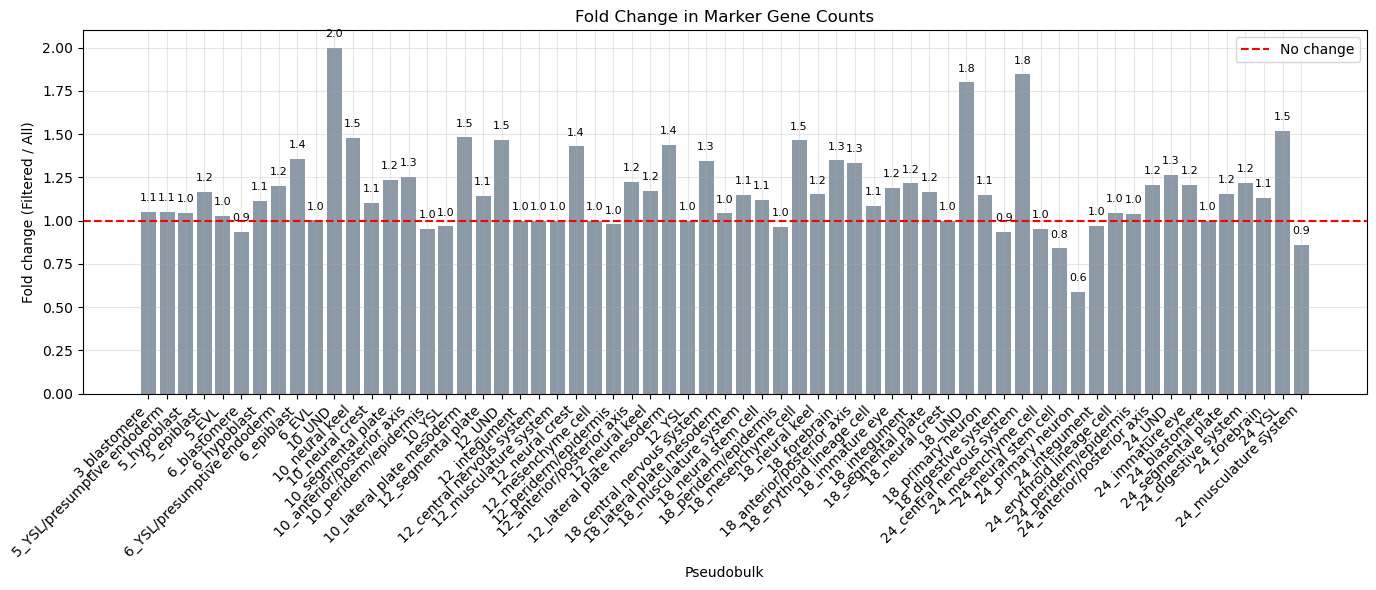

In [18]:
def plot_marker_gene_fold_change(marker_genes_all, marker_genes_filtered, title="Fold Change in Marker Gene Counts"):
    def extract_stage(group_name):
        try:
            return int(group_name.split('_')[0])
        except:
            return float('inf')

    all_groups = set(marker_genes_all.keys()) | set(marker_genes_filtered.keys())
    sorted_groups = sorted(all_groups, key=extract_stage)

    fold_changes = []
    for group in sorted_groups:
        count_all = len(marker_genes_all.get(group, []))
        count_filtered = len(marker_genes_filtered.get(group, []))
        if count_all > 0:
            fc = count_filtered / count_all
        else:
            fc = float('inf') if count_filtered > 0 else 1
        fold_changes.append(fc)

    capped_fc = [min(fc, 2.0) if fc != float('inf') else 2.0 for fc in fold_changes]

    plt.figure(figsize=(14, 6))
    bars = plt.bar(sorted_groups, capped_fc, alpha=0.8, color='slategrey')
    plt.axhline(1.0, color='red', linestyle='--', label='No change')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Pseudobulk")
    plt.ylabel("Fold change (Filtered / All)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)

    for bar, fc in zip(bars, fold_changes):
        label = f"{fc:.1f}" if fc != float('inf') else "inf"
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05, 
                 label, ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


def plot_marker_gene_counts(marker_genes_dict, title="Number of Marker Genes per Pseudobulk"):
    def extract_stage(group_name):
        try:
            return int(group_name.split('_')[0])
        except:
            return float('inf')

    sorted_groups = sorted(marker_genes_dict.keys(), key=extract_stage)
    counts = [len(marker_genes_dict[group]) for group in sorted_groups]

    plt.figure(figsize=(14, 6))
    bars = plt.bar(sorted_groups, counts, alpha=0.8, color='steelblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Pseudobulk")
    plt.ylabel("Number of Marker Genes")
    plt.title(title)
    plt.grid(True, alpha=0.3)

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
                 str(count), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


results = plot_marker_gene_fold_change(
    marker_genes_pseudobulk, 
    marker_genes_pseudobulk_high_exp_genes,
)


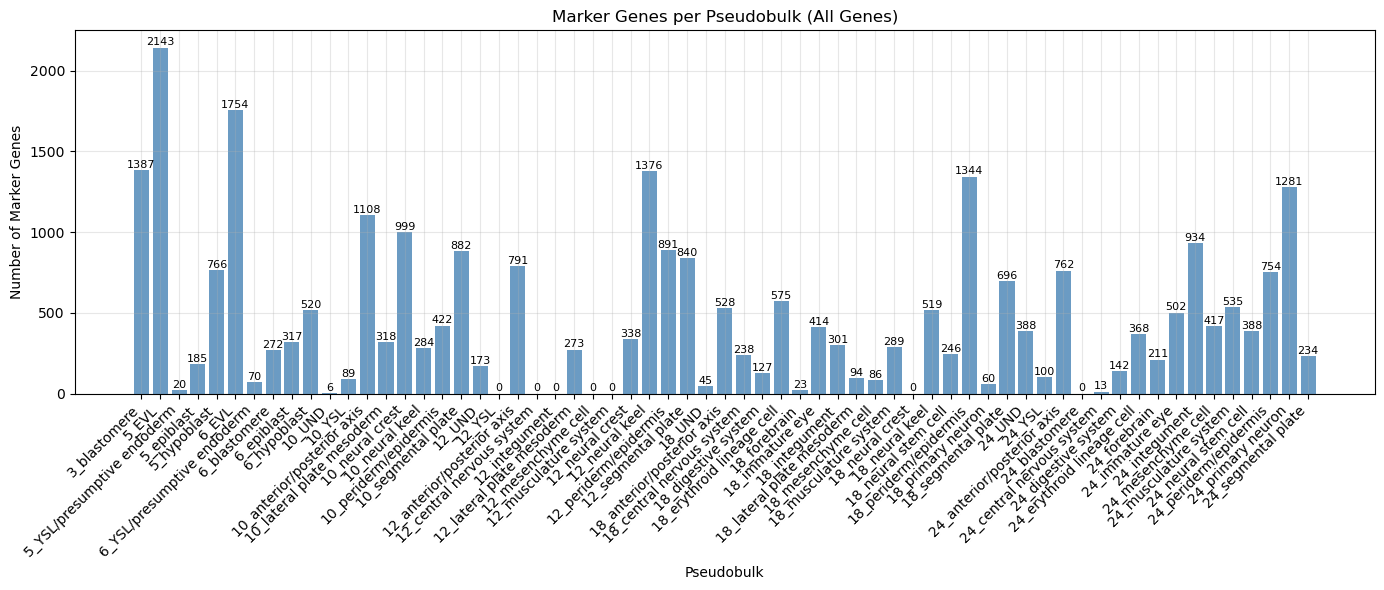

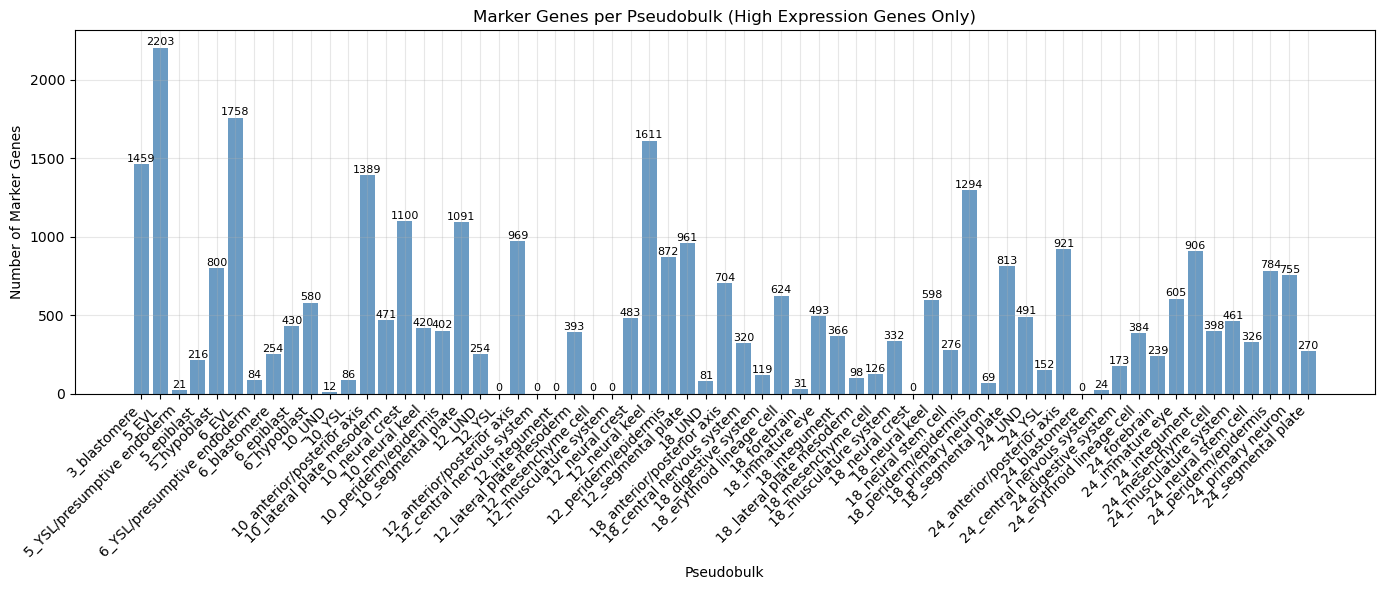

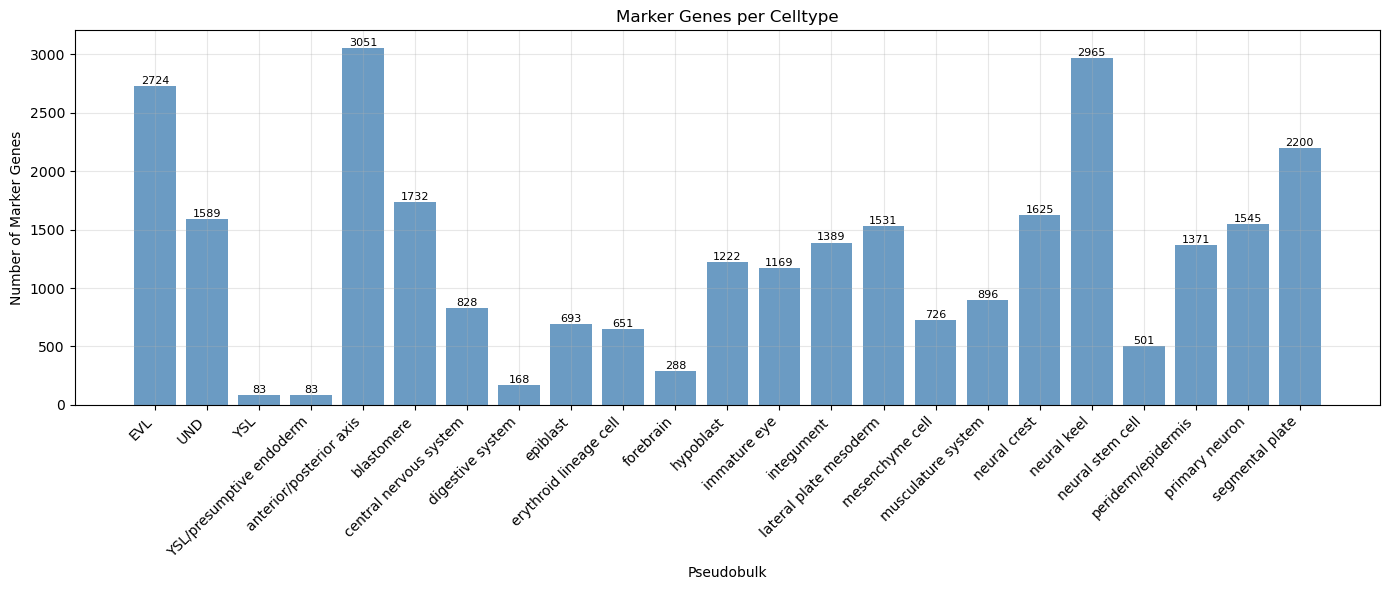

In [19]:

plot_marker_gene_counts(marker_genes_pseudobulk, title="Marker Genes per Pseudobulk (All Genes)")
plot_marker_gene_counts(marker_genes_pseudobulk_high_exp_genes, title="Marker Genes per Pseudobulk (High Expression Genes Only)")
plot_marker_gene_counts(marker_genes_celltype, title="Marker Genes per Celltype")





In [20]:
# filter rows of rna_mean_filtereed_genes to only keep rows that are in marker_genes_set
rna_mean_markers = rna_mean_filtered_genes.loc[rna_mean_filtered_genes.index.intersection(marker_genes_set)]
rna_mean_markers
# filter rna_high_genes_Unmatched to have the same genes as rna_mean_markers
rna_high_genes_Unmatched_markers = rna_high_genes_Unmatched.loc[rna_high_genes_Unmatched.index.intersection(marker_genes_set)]
rna_high_genes_Unmatched_markers

10h-1_CELL1140_N1_10h-1  10h-1_CELL1447_N1_10h-1  \
                                                             
rpl13a                   5.554589                 4.523562   
khdrbs1a                 6.357552                 5.906891   
apoeb                    6.614710                 6.870365   
cfl1                     3.584963                 3.321928   
polr2d                   2.584963                 1.000000   
...                           ...                      ...   
cdk5r2a                  0.000000                 0.000000   
slc12a5b                 0.000000                 0.000000   
he1.3                    0.000000                 0.000000   
phyhip                   0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL1347_N1_10h-1  10h-1_CELL1204_N1_10h-1  \
                                                             
rpl13a                   4.807355                 4.247928   
khdrbs1a                 5.209453                 5.930737   
apoeb                    7.599913                 4.700440   
cfl1                     3.459432                 4.459432   
polr2d                   1.000000                 2.807355   
...                           ...                      ...   
cdk5r2a                  0.000000                 0.000000   
slc12a5b                 0.000000                 0.000000   
he1.3                    0.000000                 0.000000   
phyhip                   0.000000                 0.000000   
dharma                   0.000000                 0.000000   

          10h-1_CELL97_N2_10h-1  10h-1_CELL539_N1_10h-1  \
                                                          
rpl13a                 6.209453                6.228819   
khdrbs1a               7.294621                7.375039   
apoeb                  4.754888                9.144658   
cfl1                   4.954196                5.247928   
polr2d                 2.000000                2.000000   
...                         ...                     ...   
cdk5r2a                0.000000                0.000000   
slc12a5b               0.000000                0.000000   
he1.3                  0.000000                0.000000   
phyhip                 0.000000                0.000000   
dharma                 0.000000                0.000000   

          10h-1_CELL310_N1_10h-1  10h-1_CELL311_N1_10h-1  \
                                                           
rpl13a                  6.507795                6.599913   
khdrbs1a                7.531381                7.599913   
apoeb                   6.554589                5.554589   
cfl1                    5.614710                6.044394   
polr2d                  2.584963                2.807355   
...                          ...                     ...   
cdk5r2a                 0.000000                0.000000   
slc12a5b                0.000000                0.000000   
he1.3                   0.000000                0.000000   
phyhip                  0.000000                0.000000   
dharma                  0.000000                0.000000   

          10h-1_CELL665_N1_10h-1  10h-1_CELL350_N1_10h-1  ...  \
                                                          ...   
rpl13a                  5.882643                5.754888  ...   
khdrbs1a                6.894818                7.228819  ...   
apoeb                   6.569856                7.149747  ...   
cfl1                    4.906891                5.392317  ...   
polr2d                  1.000000                3.000000  ...   
...                          ...                     ...  ...   
cdk5r2a                 0.000000                0.000000  ...   
slc12a5b                0.000000                0.000000  ...   
he1.3                   0.000000                0.000000  ...   
phyhip                  0.000000                0.000000  ...   
dharma                  0.000000                0.000000  ...   

 

In [21]:
def assign_cells_to_pseudobulks(rna_data_unmatched, rna_data_mean_pseudobulk):
    unmatched_matrix = rna_data_unmatched.T.values 
    pseudobulk_matrix = rna_data_mean_pseudobulk.T.values 
    distance_matrix = cdist(unmatched_matrix, pseudobulk_matrix, metric='euclidean')
    pseudobulk_names = list(rna_data_mean_pseudobulk.columns)
    cell_names = list(rna_data_unmatched.columns)
    closest_indices = np.argmin(distance_matrix, axis=1)
    closest_pseudobulks = [pseudobulk_names[i] for i in closest_indices]
    closest_distances = distance_matrix[np.arange(len(cell_names)), closest_indices]
    cell_to_pseudobulk = dict(zip(cell_names, closest_pseudobulks))
    cell_to_distance = dict(zip(cell_names, closest_distances))

    return cell_to_pseudobulk, cell_to_distance

cell_to_pseudobulk_filtered_genes, cell_to_distance_filtered_genes = assign_cells_to_pseudobulks(rna_high_genes_Unmatched_markers, rna_mean_markers)
cell_to_pseudobulk_all_genes,cell_to_distance_all_genes= assign_cells_to_pseudobulks(rna_data_unmatched_all_genes, rna_mean_all_genes)
print(cell_to_distance_filtered_genes)
print(cell_to_distance_all_genes)

{'10h-1_CELL1140_N1_10h-1': np.float64(58.12541163933619), '10h-1_CELL1447_N1_10h-1': np.float64(62.351587766007135), '10h-1_CELL1347_N1_10h-1': np.float64(63.85490096231696), '10h-1_CELL1204_N1_10h-1': np.float64(57.47823326228526), '10h-1_CELL97_N2_10h-1': np.float64(65.5345894699786), '10h-1_CELL539_N1_10h-1': np.float64(66.7988263745858), '10h-1_CELL310_N1_10h-1': np.float64(74.7662297832048), '10h-1_CELL311_N1_10h-1': np.float64(73.71414889547626), '10h-1_CELL665_N1_10h-1': np.float64(63.75971681243008), '10h-1_CELL350_N1_10h-1': np.float64(75.6848299361207), '10h-1_CELL434_N1_10h-1': np.float64(71.90064144274466), '10h-1_CELL335_N1_10h-1': np.float64(73.14021014191906), '10h-1_CELL1086_N1_10h-1': np.float64(58.07164759622711), '10h-1_CELL2213_N1_10h-1': np.float64(49.68715449564257), '10h-1_CELL646_N1_10h-1': np.float64(60.438020095216004), '10h-1_CELL320_N1_10h-1': np.float64(80.26086630449684), '10h-1_CELL149_N2_10h-1': np.float64(82.19435668552698), '10h-1_CELL1088_N1_10h-1': 

#### Assign each unmatched RNA cell to the pseudobulk with the minimum euyclidean distance 
- use only genes with log2(x+1) expression >= 4 for at least one pseudobulk

- use only pseudobulk specific marker genes for each iteration

#### replace cell column names in rna_data_log with the values of the dictionaries 
    - cell_to_psd_with_markers for unmatched cells 
    - cell_to_psd_with_markers for matched_cells

#### group by pseudobulk name and the mean values 

In [22]:
#@ print some entries of the dictionariy
for cell, pb in list(cell_to_pseudobulk_filtered_genes.items())[:20]:
    print(cell, pb)

10h-1_CELL1140_N1_10h-1 6_epiblast
10h-1_CELL1447_N1_10h-1 6_epiblast
10h-1_CELL1347_N1_10h-1 24_UND
10h-1_CELL1204_N1_10h-1 12_anterior/posterior axis
10h-1_CELL97_N2_10h-1 12_neural keel
10h-1_CELL539_N1_10h-1 12_neural crest
10h-1_CELL310_N1_10h-1 18_neural keel
10h-1_CELL311_N1_10h-1 18_neural keel
10h-1_CELL665_N1_10h-1 10_anterior/posterior axis
10h-1_CELL350_N1_10h-1 10_neural crest
10h-1_CELL434_N1_10h-1 24_anterior/posterior axis
10h-1_CELL335_N1_10h-1 10_anterior/posterior axis
10h-1_CELL1086_N1_10h-1 12_segmental plate
10h-1_CELL2213_N1_10h-1 5_YSL/presumptive endoderm
10h-1_CELL646_N1_10h-1 10_anterior/posterior axis
10h-1_CELL320_N1_10h-1 10_neural crest
10h-1_CELL149_N2_10h-1 10_neural crest
10h-1_CELL1088_N1_10h-1 12_anterior/posterior axis
10h-1_CELL712_N1_10h-1 12_neural keel
10h-1_CELL1097_N1_10h-1 18_central nervous system


#### plot the number of cells in unmatched and matched pseudobulks

In [23]:
import os
def plot_distance_distributions_by_celltype(cell_to_psd_with_markers,
                                          cell_to_psd_dist_with_markers,
                                          cutoffs_df,
                                          output_dir="distance_violin_plots"):
    os.makedirs(output_dir, exist_ok=True)
    df = pd.DataFrame({
        "cell": list(cell_to_psd_with_markers.keys()),
        "pseudobulk": [cell_to_psd_with_markers[c] for c in cell_to_psd_with_markers],
        "distance": [cell_to_psd_dist_with_markers[c] for c in cell_to_psd_with_markers]
    })

    df['celltype'] = df['pseudobulk'].str.split('_').str[1:]  # Everything after first underscore
    df['celltype'] = df['celltype'].apply(lambda x: '_'.join(x) if isinstance(x, list) else x)
    df['stage'] = df['pseudobulk'].str.split('_').str[0]  # First part before underscore
    
    unique_celltypes = sorted(df['celltype'].unique())
    all_stages = sorted(df['stage'].unique(), key=lambda x: int(x) if x.isdigit() else 999)
    
    fig, axes = plt.subplots(len(unique_celltypes), 1, 
                            figsize=(max(8, len(all_stages) * 1.5), 5 * len(unique_celltypes)),
                            sharex=True)
    
    if len(unique_celltypes) == 1:
        axes = [axes]
    
    #  create a subplot pewr cell type
    for idx, celltype in enumerate(unique_celltypes):
        celltype_df = df[df['celltype'] == celltype]
        
        # Sort stages numerically 
        stages = sorted(celltype_df['stage'].unique(), 
                       key=lambda x: int(x))
    
        sns.violinplot(data=celltype_df, x='stage', y='distance', 
                      inner='quartile', order=stages, palette='Set2', ax=axes[idx])
        
        # cutoff lines for each stage
        for i, stage in enumerate(stages):
            stage_pseudobulk = f"{stage}_{celltype}"
            cutoff = cutoffs_df[cutoffs_df['pseudobulk'] == stage_pseudobulk]['cutoff'].values
            if len(cutoff) > 0:
                axes[idx].axhline(y=cutoff[0], color='red', linestyle='--', alpha=0.7,
                                 xmin=(i)/(len(stages)), xmax=(i+1)/(len(stages)))
        
        axes[idx].set_title(f"Distance Distribution by Stage - {celltype}")
        axes[idx].set_ylabel("Euclidean Distance")
        
        # Only show x-axis label on the bottom subplot
        if idx == len(unique_celltypes) - 1:
            axes[idx].set_xlabel("Stage")
        else:
            axes[idx].set_xlabel("")
    
    axes[0].legend()
    plt.tight_layout()
    plt.suptitle("Pseudobulk Enrichment: \n Distance to Closest Pseudobulk ", fontsize=16, fontweight='bold', y=1.02)
    plt.savefig(os.path.join(output_dir, "all_celltypes_stages_violin.png"), 
               dpi=300, bbox_inches='tight')
    plt.close()

plot_distance_distributions_by_celltype(
    cell_to_pseudobulk_filtered_genes,
    cell_to_distance_filtered_genes,
    cutoffs_high_exp_genes_Celltype,
    output_dir="../../data/embryo/plots"
)

/tmp/ipykernel_65543/2312992614.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=celltype_df, x='stage', y='distance',
/tmp/ipykernel_65543/2312992614.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=celltype_df, x='stage', y='distance',
/tmp/ipykernel_65543/2312992614.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=celltype_df, x='stage', y='distance',
/tmp/ipykernel_65543/2312992614.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the

In [24]:
def filter_and_aggregate_by_pseudobulk(rna_data, cell_to_pseudobulk, cell_to_distance, cutoffs_df):
    pseudobulk_to_cutoff = dict(zip(cutoffs_df['pseudobulk'], cutoffs_df['cutoff']))
    
    filtered = [
        (cell, cell_to_pseudobulk[cell], cell_to_distance[cell])
        for cell in rna_data.columns
        if cell in cell_to_pseudobulk
        and cell in cell_to_distance
        and cell_to_pseudobulk[cell] in pseudobulk_to_cutoff
        and cell_to_distance[cell] <= pseudobulk_to_cutoff[cell_to_pseudobulk[cell]]
    ]
    filtered_cells, pseudobulks, distances = zip(*filtered)
    
    info_df = pd.DataFrame({
        'cell': filtered_cells,
        'assigned_pseudobulk': pseudobulks,
        'distance': distances
    })
    
    data = rna_data[list(filtered_cells)].copy()
    data.columns = pseudobulks
    aggregated = data.groupby(data.columns, axis=1).mean()
    
    return aggregated, info_df

enriched_data_mean_markers, cell_assignment_info_markers = filter_and_aggregate_by_pseudobulk(
    rna_high_genes_Unmatched_markers, 
    cell_to_pseudobulk_filtered_genes, 
    cell_to_distance_filtered_genes, 
    cutoffs_high_exp_genes_Celltype)


/tmp/ipykernel_65543/2764545142.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  aggregated = data.groupby(data.columns, axis=1).mean()


In [25]:
enriched_data_mean_markers

10_UND    10_YSL  10_anterior/posterior axis  \
                                                           
rpl13a    4.892720  1.848079                    6.241592   
khdrbs1a  4.728305  3.237821                    7.028345   
apoeb     1.432494  7.191900                    5.635373   
cfl1      3.818588  0.000000                    5.101383   
polr2d    0.992424  0.750000                    2.352262   
...            ...       ...                         ...   
cdk5r2a   0.000000  0.000000                    0.000000   
slc12a5b  0.000000  0.000000                    0.000000   
he1.3     0.000000  0.000000                    0.000000   
phyhip    0.000000  0.000000                    0.000000   
dharma    0.000000  0.000000                    0.000000   

          10_lateral plate mesoderm  10_neural crest  10_neural keel  \
                                                                       
rpl13a                     6.041452         6.099903        5.608426   
khdrbs1a                   6.920948         7.664514        6.611451   
apoeb                      5.184560         7.025066        5.040118   
cfl1                       5.313143         5.716914        4.472795   
polr2d                     2.346026         2.627789        1.904996   
...                             ...              ...             ...   
cdk5r2a                    0.000000         0.000000        0.000000   
slc12a5b                   0.000000         0.001854        0.000000   
he1.3                      0.000000         0.000000        0.000000   
phyhip                     0.000000         0.000000        0.000000   
dharma                     0.000000         0.006401        0.000000   

          10_periderm/epidermis  10_segmental plate    12_UND  \
                                                                
rpl13a                 3.627188            6.144637  6.037003   
khdrbs1a               1.982379            6.568617  6.238618   
apoeb                  0.345696            5.453895  3.258029   
cfl1                   0.515889            4.639684  4.980724   
polr2d                 0.220098            2.211284  1.748083   
...                         ...                 ...       ...   
cdk5r2a                0.000000            0.000000  0.000000   
slc12a5b               0.000000            0.000000  0.002994   
he1.3                  0.183671            0.000000  0.000000   
phyhip                 0.000000            0.000000  0.000000   
dharma                 0.000000            0.000000  0.000000   

          12_anterior/posterior axis  ...  24_segmental plate  3_blastomere  \
                                      ...                                     
rpl13a                      5.508186  ...            5.246420      3.133592   
khdrbs1a                    6.098792  ...            5.185082      5.683652   
apoeb                       4.384712  ...            4.178590      2.377870   
cfl1                        4.340304  ...            3.757209      5.002746   
polr2d                      1.680457  ...            1.254052      1.402059   
...                              ...  ...                 ...           ...   
cdk5r2a                     0.000000  ...            0.000000      0.000000   
slc12a5b                    0.000000  ...            0.000000      0.001325   
he1.3                       0.000000  ...            0.000000      0.000000   
phyhip                      0.000000  ...            0.000000      0.000000   
dharma                      0.000000  ...            0.000000      0.082544   

             5_EVL  5_YSL/presumptive endoderm  5_epiblast  5_hypoblast  \
                                                                          
rpl13a    4.955015                    2.641763    2.664455     3.551318   
khdrbs1a  7.927563                    2.651886    5.925122     6.610326   
apoeb     2.659192                    1.127900    4.327209     4.949616   
cfl1      5.820834                    1.61065

In [26]:
cell_assignment_info_markers
# print how many cells were assigned to each pseudobulk
pseudobulk_counts = cell_assignment_info_markers['assigned_pseudobulk'].value_counts()
pseudobulk_counts

assigned_pseudobulk
24_neural stem cell           10451
5_YSL/presumptive endoderm     5517
5_epiblast                     5219
3_blastomere                   4214
6_YSL/presumptive endoderm     3419
24_YSL                         3409
24_mesenchyme cell             3408
18_central nervous system      2578
12_neural keel                 2569
6_epiblast                     2470
5_hypoblast                    2090
24_primary neuron              1674
24_forebrain                   1619
12_neural crest                1515
18_neural keel                 1250
6_hypoblast                    1234
18_integument                  1198
24_integument                  1092
10_neural crest                1079
24_central nervous system       898
24_UND                          852
10_anterior/posterior axis      817
24_erythroid lineage cell       598
6_EVL                           579
24_segmental plate              558
18_mesenchyme cell              552
24_immature eye                 490
12_anter

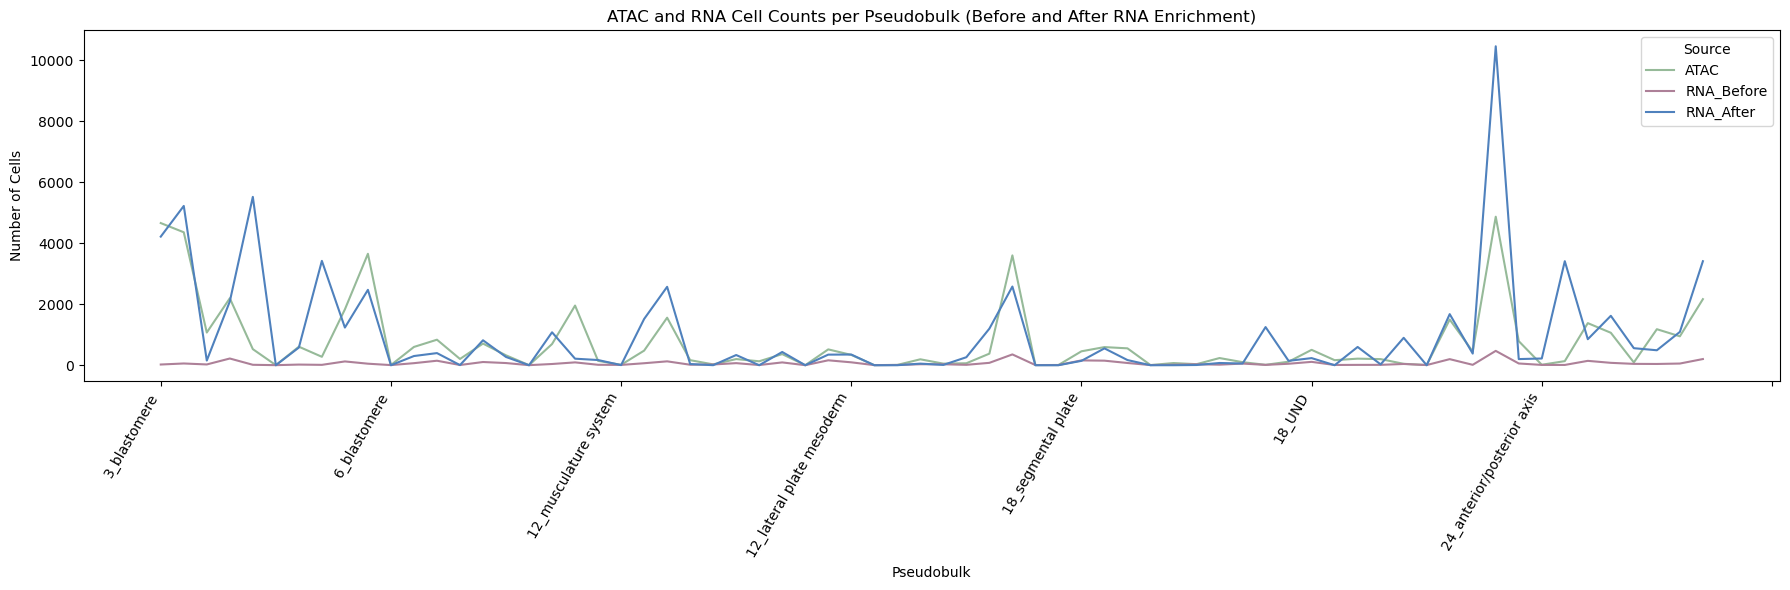

In [41]:

atac_counts = atac_metadata_df.groupby('pseudobulk')['atac_cell'].nunique().reset_index(name='ATAC')
rna_counts = atac_metadata_df.groupby('pseudobulk')['rna_matching_cell'].nunique().reset_index(name='RNA_Before')

rna_after_df = pseudobulk_counts.reset_index()
rna_after_df.columns = ['pseudobulk', 'RNA_After']
all_counts = atac_counts.merge(rna_counts, on='pseudobulk', how='outer')
all_counts = all_counts.merge(rna_after_df, on='pseudobulk', how='outer').fillna(0)
all_counts[['ATAC', 'RNA_Before', 'RNA_After']] = all_counts[['ATAC', 'RNA_Before', 'RNA_After']].astype(int)
all_counts['sort_key'] = all_counts['pseudobulk'].str.extract(r'^(\d+)').astype(int)
all_counts_sorted = all_counts.sort_values('sort_key')

ax = all_counts_sorted.set_index('pseudobulk')[['ATAC', 'RNA_Before', 'RNA_After']].plot(
    kind='line',
    figsize=(18, 6),
    color=['#96ba99', '#ad8098', '#4f81bd']
)

plt.xticks(rotation=60, ha='right')
plt.xlabel('Pseudobulk')
plt.ylabel('Number of Cells')
plt.title('ATAC and RNA Cell Counts per Pseudobulk (Before and After RNA Enrichment)')
plt.legend(title='Source')
plt.tight_layout()

fig_path_all = '../../data/embryo/rna_atac_cell_counts_per_pseudobulk_all.png'
plt.savefig(fig_path_all, bbox_inches='tight')
plt.show()


In [43]:
rna_mean_markers

10_UND    10_YSL  10_anterior/posterior axis  \
                                                           
rpl13a    5.084864  2.292481                    5.977550   
khdrbs1a  4.742312  3.284928                    6.498762   
apoeb     2.446045  6.575984                    4.891290   
cfl1      3.911818  2.292481                    4.642868   
polr2d    1.181378  0.000000                    1.874917   
...            ...       ...                         ...   
cdk5r2a   0.000000  0.000000                    0.000000   
slc12a5b  0.000000  0.000000                    0.000000   
he1.3     0.000000  0.000000                    0.000000   
phyhip    0.000000  0.000000                    0.000000   
dharma    0.000000  0.000000                    0.000000   

          10_lateral plate mesoderm  10_neural crest  10_neural keel  \
                                                                       
rpl13a                     5.505295         5.860131        5.471751   
khdrbs1a                   6.354888         6.985411        6.233713   
apoeb                      4.907480         6.666729        4.654771   
cfl1                       4.655234         4.435093        4.392690   
polr2d                     1.880436         1.776963        1.805762   
...                             ...              ...             ...   
cdk5r2a                    0.000000         0.000000        0.000000   
slc12a5b                   0.000000         0.000000        0.000000   
he1.3                      0.000000         0.000000        0.000000   
phyhip                     0.000000         0.000000        0.000000   
dharma                     0.000000         0.000000        0.000000   

          10_periderm/epidermis  10_segmental plate    12_UND    12_YSL  ...  \
                                                                         ...   
rpl13a                 4.346743            5.809875  5.433258  1.584963  ...   
khdrbs1a               2.729716            6.072204  5.686432  3.700440  ...   
apoeb                  0.000000            4.813227  3.869535  0.000000  ...   
cfl1                   0.000000            4.284868  4.602898  3.000000  ...   
polr2d                 0.000000            1.900582  1.602456  0.000000  ...   
...                         ...                 ...       ...       ...  ...   
cdk5r2a                0.000000            0.000000  0.000000  0.000000  ...   
slc12a5b               0.000000            0.000000  0.000000  0.000000  ...   
he1.3                  0.000000            0.000000  0.000000  0.000000  ...   
phyhip                 0.000000            0.000000  0.000000  0.000000  ...   
dharma                 0.000000            0.000000  0.000000  0.000000  ...   

          24_segmental plate  3_blastomere     5_EVL  \
                                                       
rpl13a              5.729210      2.850926  4.662160   
khdrbs1a            5.015834      5.354773  7.578096   
apoeb               4.124131      2.321131  2.223308   
cfl1                3.988292      4.364861  5.546121   
polr2d              1.472313      1.321714  1.166667   
...                      ...           ...       ...   
cdk5r2a             0.000000      0.000000  0.000000   
slc12a5b            0.000000      0.000000  0.000000   
he1.3               0.000000      0.000000  0.000000   
phyhip              0.000000      0.000000  0.000000   
dharma              0.000000      0.058824  0.000000   

          5_YSL/presumptive endoderm  5_epiblast  5_hypoblast     6_EVL  \
                                                                          
rpl13a                      1.935785    2.623231     3.276358  4.178352   
khdrbs1a                    3.043094    6.082239     6.388591  6.952145   
apoeb                       5.098626    4.674749     4.360641  1.392333   
cfl1                        2.194988    3.169378     3.684791  4.788534   
polr2d                      0.000000    0.628456     1.095659  0.685348   

In [27]:
mean_combined_markers = ((enriched_data_mean_markers + rna_mean_markers) / 2)[enriched_data_mean_markers.columns.intersection(rna_mean_markers.columns)]
mean_combined_markers.columns = [f"{col}_combined" for col in mean_combined_markers.columns]
mean_combined_markers


10_UND_combined  10_YSL_combined  \
                                             
rpl13a           4.988792         2.070280   
khdrbs1a         4.735308         3.261374   
apoeb            1.939269         6.883942   
cfl1             3.865203         1.146241   
polr2d           1.086901         0.375000   
...                   ...              ...   
cdk5r2a          0.000000         0.000000   
slc12a5b         0.000000         0.000000   
he1.3            0.000000         0.000000   
phyhip           0.000000         0.000000   
dharma           0.000000         0.000000   

          10_anterior/posterior axis_combined  \
                                                
rpl13a                               6.109571   
khdrbs1a                             6.763554   
apoeb                                5.263331   
cfl1                                 4.872125   
polr2d                               2.113589   
...                                       ...   
cdk5r2a                              0.000000   
slc12a5b                             0.000000   
he1.3                                0.000000   
phyhip                               0.000000   
dharma                               0.000000   

          10_lateral plate mesoderm_combined  10_neural crest_combined  \
                                                                         
rpl13a                              5.773373                  5.980017   
khdrbs1a                            6.637918                  7.324962   
apoeb                               5.046020                  6.845897   
cfl1                                4.984188                  5.076003   
polr2d                              2.113231                  2.202376   
...                                      ...                       ...   
cdk5r2a                             0.000000                  0.000000   
slc12a5b                            0.000000                  0.000927   
he1.3                               0.000000                  0.000000   
phyhip                              0.000000                  0.000000   
dharma                              0.000000                  0.003201   

          10_neural keel_combined  10_periderm/epidermis_combined  \
                                                                    
rpl13a                   5.540089                        3.986966   
khdrbs1a                 6.422582                        2.356047   
apoeb                    4.847444                        0.172848   
cfl1                     4.432742                        0.257945   
polr2d                   1.855379                        0.110049   
...                           ...                             ...   
cdk5r2a                  0.000000                        0.000000   
slc12a5b                 0.000000                        0.000000   
he1.3                    0.000000                        0.091835   
phyhip                   0.000000                        0.000000   
dharma                   0.000000                        0.000000   

          10_segmental plate_combined  12_UND_combined  \
                                                         
rpl13a                       5.977256         5.735130   
khdrbs1a                     6.320411         5.962525   
apoeb                        5.133561         3.563782   
cfl1                         4.462276         4.791811   
polr2d                       2.055933         1.675270   
...                               ...              ...   
cdk5r2a                      0.000000         0.000000   
slc12a5b                     0.000000         0.001497   
he1.3                        0.000000         0.000000   
phyhip                       0.000000         0.000000   
dharma                       0.000000         0.000000   

          12_anterior/posterior axis_combined  ...  \
                                               ...   
rpl13a                               5.610301  ..

In [44]:
mean_combined_markers.to_csv('../../data/embryo/processed/gEX_enriched_psd.csv')

In [28]:
enriched_data_mean_all_genes, cell_assignment_info_all_genes = filter_and_aggregate_by_pseudobulk(
    rna_data_unmatched_all_genes, 
    cell_to_pseudobulk_filtered_genes, 
    cell_to_distance_filtered_genes, 
    cutoffs_high_exp_genes_Celltype)


/tmp/ipykernel_65543/2764545142.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  aggregated = data.groupby(data.columns, axis=1).mean()


/tmp/ipykernel_65543/497035428.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


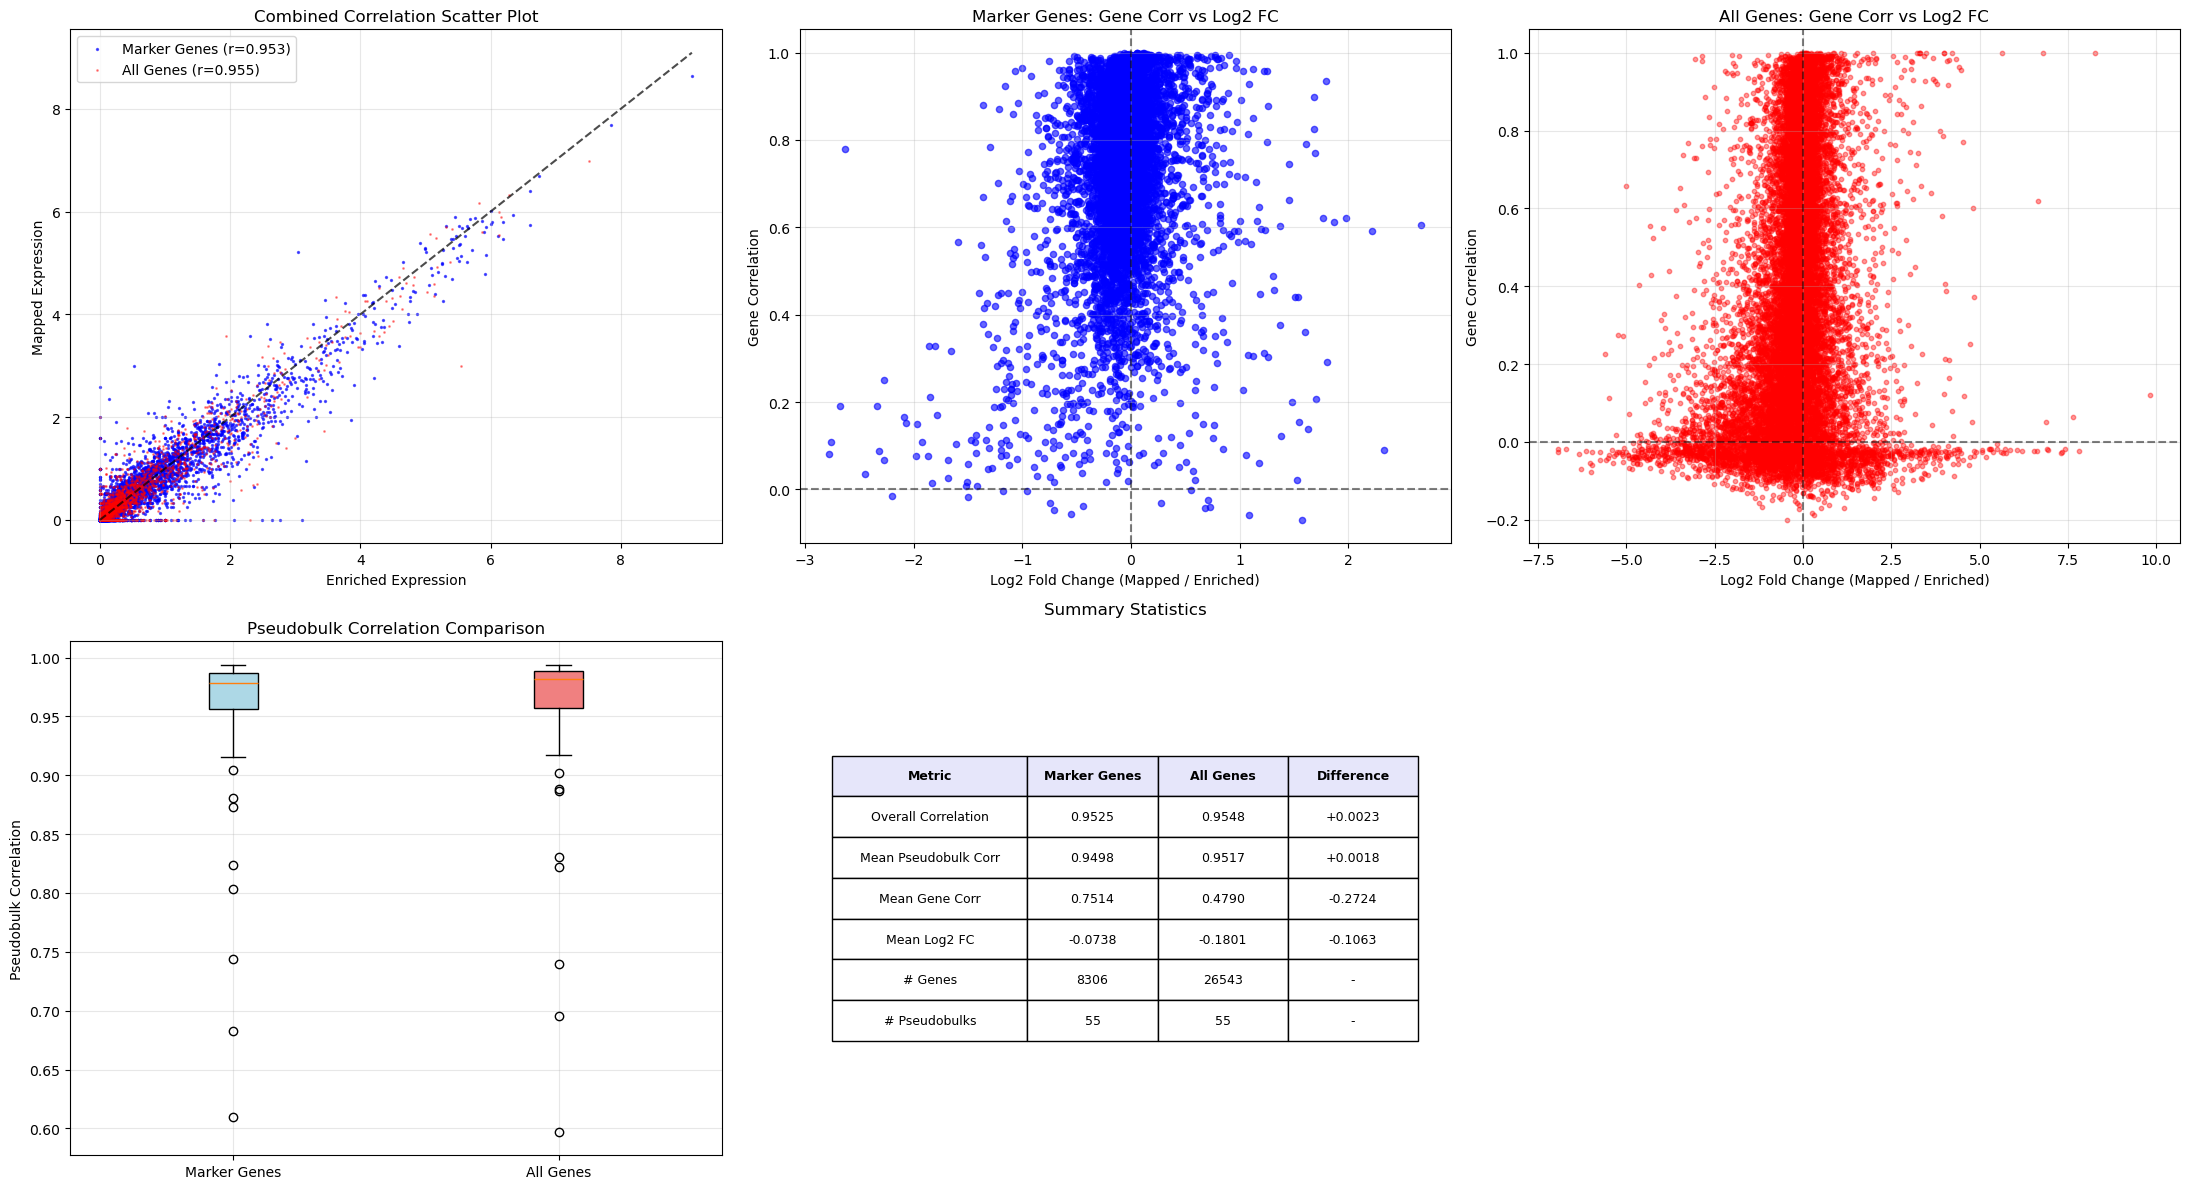

In [ ]:

def compare_marker_vs_all_genes_enhanced(enriched_markers, mapped_markers, 
                                         enriched_all_genes, mapped_all_genes,
                                         output_dir="marker_vs_all_comparison"):

    os.makedirs(output_dir, exist_ok=True)
    
    def analyze_pair(df1, df2):
        common_cols = list(set(df1.columns) & set(df2.columns))
        common_rows = list(set(df1.index) & set(df2.index))
        df1_common = df1.loc[common_rows, common_cols]
        df2_common = df2.loc[common_rows, common_cols]

        overall_corr, _ = pearsonr(df1_common.values.flatten(), df2_common.values.flatten())
        pseudobulk_corrs = [pearsonr(df1_common[col], df2_common[col])[0] for col in common_cols]

        gene_corrs = []
        for gene in common_rows:
            if df1_common.loc[gene].std() > 0 and df2_common.loc[gene].std() > 0:
                corr, _ = pearsonr(df1_common.loc[gene], df2_common.loc[gene])
                gene_corrs.append(corr)

        return {
            'overall_corr': overall_corr,
            'pseudobulk_corrs': pseudobulk_corrs,
            'gene_corrs': gene_corrs,
            'n_genes': len(common_rows),
            'n_pseudobulks': len(common_cols),
            'df1_common': df1_common,
            'df2_common': df2_common
        }

    marker_results = analyze_pair(enriched_markers, mapped_markers)
    all_genes_results = analyze_pair(enriched_all_genes, mapped_all_genes)

    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    
    # Combined scatter plot
    ax = axes[0, 0]
    def flatten_sample(df1, df2, max_points=5000):
        x = df1.values.flatten()
        y = df2.values.flatten()
        if len(x) > max_points:
            idx = np.random.choice(len(x), max_points, replace=False)
            x, y = x[idx], y[idx]
        return x, y
    
    mx, my = flatten_sample(marker_results['df1_common'], marker_results['df2_common'])
    ax.scatter(mx, my, alpha=0.6, s=2, color='blue', label=f'Marker Genes (r={marker_results["overall_corr"]:.3f})')
    
    axx, ayy = flatten_sample(all_genes_results['df1_common'], all_genes_results['df2_common'])
    ax.scatter(axx, ayy, alpha=0.4, s=1, color='red', label=f'All Genes (r={all_genes_results["overall_corr"]:.3f})')
    
    min_val = min(np.min(mx), np.min(my), np.min(axx), np.min(ayy))
    max_val = max(np.max(mx), np.max(my), np.max(axx), np.max(ayy))
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7)
    ax.set_xlabel('Enriched Expression')
    ax.set_ylabel('Mapped Expression')
    ax.set_title('Combined Correlation Scatter Plot')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Gene Correlation vs Log2 Fold Change (split into two subplots)
    def extract_corr_and_lfc(results):
        corrs, lfcs = [], []
        for gene in results['df1_common'].index:
            x, y = results['df1_common'].loc[gene], results['df2_common'].loc[gene]
            if x.std() > 0 and y.std() > 0:
                corrs.append(pearsonr(x, y)[0])
                lfc = np.log2((y.mean() + 1e-6) / (x.mean() + 1e-6))
                lfcs.append(lfc)
        return corrs, lfcs

    marker_gene_corrs, marker_lfc = extract_corr_and_lfc(marker_results)
    all_genes_gene_corrs, all_genes_lfc = extract_corr_and_lfc(all_genes_results)

    ax = axes[0, 1]
    ax.scatter(marker_lfc, marker_gene_corrs, alpha=0.6, s=20, color='blue')
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_title('Marker Genes: Gene Corr vs Log2 FC')
    ax.set_xlabel('Log2 Fold Change (Mapped / Enriched)')
    ax.set_ylabel('Gene Correlation')
    ax.grid(True, alpha=0.3)

    ax = axes[0, 2]
    ax.scatter(all_genes_lfc, all_genes_gene_corrs, alpha=0.4, s=10, color='red')
    ax.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_title('All Genes: Gene Corr vs Log2 FC')
    ax.set_xlabel('Log2 Fold Change (Mapped / Enriched)')
    ax.set_ylabel('Gene Correlation')
    ax.grid(True, alpha=0.3)

    # Pseudobulk correlation boxplot
    ax = axes[1, 0]
    box = ax.boxplot(
        [marker_results['pseudobulk_corrs'], all_genes_results['pseudobulk_corrs']],
        labels=['Marker Genes', 'All Genes'],
        patch_artist=True
    )
    box['boxes'][0].set_facecolor('lightblue')
    box['boxes'][1].set_facecolor('lightcoral')
    ax.set_ylabel('Pseudobulk Correlation')
    ax.set_title('Pseudobulk Correlation Comparison')
    ax.grid(True, alpha=0.3)

    # Summary Table
    ax = axes[1, 1]
    ax.axis('off')
    table_data = [
        ['Metric', 'Marker Genes', 'All Genes', 'Difference'],
        ['Overall Correlation', f'{marker_results["overall_corr"]:.4f}', 
         f'{all_genes_results["overall_corr"]:.4f}', 
         f'{all_genes_results["overall_corr"] - marker_results["overall_corr"]:+.4f}'],
        ['Mean Pseudobulk Corr', f'{np.mean(marker_results["pseudobulk_corrs"]):.4f}', 
         f'{np.mean(all_genes_results["pseudobulk_corrs"]):.4f}', 
         f'{np.mean(all_genes_results["pseudobulk_corrs"]) - np.mean(marker_results["pseudobulk_corrs"]):+.4f}'],
        ['Mean Gene Corr', f'{np.mean(marker_gene_corrs):.4f}', 
         f'{np.mean(all_genes_gene_corrs):.4f}', 
         f'{np.mean(all_genes_gene_corrs) - np.mean(marker_gene_corrs):+.4f}'],
        ['Mean Log2 FC', f'{np.mean(marker_lfc):.4f}', 
         f'{np.mean(all_genes_lfc):.4f}', 
         f'{np.mean(all_genes_lfc) - np.mean(marker_lfc):+.4f}'],
        ['# Genes', f'{marker_results["n_genes"]}', f'{all_genes_results["n_genes"]}', '-'],
        ['# Pseudobulks', f'{marker_results["n_pseudobulks"]}', f'{all_genes_results["n_pseudobulks"]}', '-']
    ]
    table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.3, 0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    for i in range(4):  # Style header
        table[(0, i)].set_facecolor('#E6E6FA')
        table[(0, i)].set_text_props(weight='bold')
    ax.set_title('Summary Statistics', pad=20)

    fig.delaxes(axes[1, 2])  # Remove the unused plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'enhanced_marker_vs_all_genes_comparison.png'), dpi=300)
    plt.show()

    return marker_results, all_genes_results, marker_lfc, all_genes_lfc


marker_results, all_genes_results, marker_lfc, all_genes_lfc = compare_marker_vs_all_genes_enhanced(
    enriched_data_mean_markers,           # enriched marker genes
    rna_mean_markers,             # mapped marker genes  
    enriched_data_mean_all_genes, # enriched all genes
    rna_mean_all_genes,           # mapped all genes
    output_dir="enhanced_marker_vs_all_comparison"
)

In [47]:
# discad the columns in atac_mean_filtered that are not in enriched_data_mean_markers
atac_mean_filtered_markers = atac_mean_filtered.loc[:, atac_mean_filtered.columns.intersection(enriched_data_mean_markers.columns)]
atac_mean_filtered_markers
# save the filtered atac_mean_filtered_markers
atac_mean_filtered_markers.to_csv('../../data/embryo/processed/atac_psd.csv')

In [ ]:
# split the first column od atac_mean_filtered_markers into 3 columns chromosome, start, end split by : and - 
atac_mean_filtered_markers[['chromosome', 'start', 'end']] = atac_mean_filtered_markers.index.str.split(':|-', expand=True)

In [48]:

def load_fasta_from_directory(fasta_dir):
    fasta_dict = {}

    for filename in sorted(os.listdir(fasta_dir)):
        if filename.endswith(".fa"):  
            chrom_number = filename.split(".")[-2]  
            chrom_key = f'chr{chrom_number}'

            with open(os.path.join(fasta_dir, filename), 'r') as f:
                chrom_seq = ''.join([line.strip().upper() for line in f if not line.startswith(">")])
            
            fasta_dict[chrom_key] = chrom_seq

    return fasta_dict

fasta_directory = "../../data/genome"
seq_dict = load_fasta_from_directory(fasta_directory)

In [ ]:
seq_dict

In [ ]:
def extract_seq(row, seq_dict):
    chrom, start, end = row['chromosome'], row['start'], row['end']

    return seq_dict[chrom][start:end]